### GIZ Initial Data Exploration
#### author: Emily Robitschek

Purpose: Before we build any model, we need to be able to take a look at the documents we have.

Some resources: 

#### papers mentioned in project proposal: 
https://medium.com/fiscalnoteworthy/citing-your-sources-79062248f468
https://www2.deloitte.com/us/en/insights/focus/cognitive-technologies/natural-language-processing-examples-in-government-data.html
https://documents1.worldbank.org/curated/en/634591516387264234/pdf/WPS8310.pdf

#### NLP related links: 
- https://spacy.io/usage/spacy-101
- https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a
- https://arunm8489.medium.com/getting-started-with-natural-language-processing-6e593e349675
- https://towardsdatascience.com/natural-language-processing-pipeline-decoded-f97a4da5dbb7

### Import libraries

In [49]:
import os
import glob
import time
import json
import codecs
import re

import scipy
import numpy as np
import pandas as pd

#set up packages for processing data types and for NLP analysis
from collections import OrderedDict, Counter
import contractions
import spacy
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span
from spacy import displacy

nlp = spacy.load('en_core_web_sm') #or the multi-language one: spacy.load('xx_ent_wiki_sm')

from n_gram_correlation import NGramCorrelateSpacy

#graphing/visualization packages: 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

### Define helper functions for preprocessing

In [50]:
from datahelper import *
from nlppreprocess import *
from nlpanalysis import *
from correlation import *
from textutils import importer

### Import data: Keywords from NDCs

In [172]:
#keywords (just for testing purposes - from the policy proposal from GIZ)
policy = ["policy", "integrate", "implement", "committee", "consultation"]
food = ["nutritions", "diets", "farm", "agriculture", "ecology"]
ndc_national_adaption_plan = ["nap", "sector plan", "nccrp", "vulnerable sector", 
                              "geographic vulnerability"]
ndc_climate_change = ["adaption", "program", "projects", "resilience", "institution",
                      "capacity", "response", "budget", "reprioritisation", "development", 
                      "planner", "regulator", "practitioners", "geographical", 
                      "circumstances", "land", "scheme", "authorisation", "system", 
                      "spluma"]
ndc_early_warning = ["system", "vulnerability", "needs", "assessment", "network", "weather",
   "earth", "observation", "academic", "community"]

#keywords from json file
json_keywords_SA_file = '../ndc_keywords/ndc_south_africa.json'
keywords_SA_dict = None
with open(json_keywords_SA_file, 'r') as f: 
    keywords_SA_dict = json.load(f)
    
    
json_keywords_Ethiopia_file = '../ndc_keywords/ndc_ethiopia.json'
keywords_Ethiopia_dict = None
with open(json_keywords_Ethiopia_file, 'r') as f: 
    keywords_Ethiopia_dict = json.load(f)
    
print(keywords_SA_dict)
print(keywords_Ethiopia_dict)
#ndc_dict = make_filtered_tokens_from_ndc(keywords_SA_dict) #if want to use filtered, lemmatized tokens
ndc_dict = keywords_SA_dict
#ndc_dict = keywords_Ethiopia_dict

{'national adaption plan': ['national adaption plan', 'adaption plan', 'nap', 'sector plan', 'nccrp', 'vulnerable sector', 'geographic vulnerability'], 'climate change': ['climate change', 'adaption program', 'adaption projects', 'resilience', 'institutional capacity', 'response', 'budget reprioritisation', 'development', 'planner', 'regulator practitioners', 'geographical circumstances', 'land use scheme', 'authorisation system', 'spatial land use management act', 'spluma', 'paris agreement', 'climate agreement'], 'early warning': ['early warning', 'system', 'vulnerability', 'needs assessment', 'weather services', 'earth observation network', 'academic community']}
{'Adaptation to climate change': ['adaptation to climate change', 'climate change adaptation', 'increase resilience', 'reduce vulnerability', 'livelihoods', 'landscapes', 'droughts floods', 'food security', 'crop varieties', 'water scarcity', 'agroforestry', 'irrigation systems', 'irrigation system', 'biodiversity', 'geothe

In [159]:
#extra functions
def make_ndc_keyword_tidy_df_from_dict(key, col_group_name, ndc_dict):
    ndc_df = pd.DataFrame({'keyword': ndc_dict[key], 
                       col_group_name: key})
    return ndc_df

def stack_tidy_ndc_dfs(col_group_name, ndc_dict):
    ndc_df = pd.DataFrame()
    for key in ndc_dict.keys():
        ndc_df_add = make_ndc_keyword_tidy_df_from_dict(key, col_group_name, ndc_dict)
        ndc_df = pd.concat([ndc_df, ndc_df_add], axis=0)
    return ndc_df

# lets apply: 
col_group_name = 'NDC'
ndc_df = stack_tidy_ndc_dfs(col_group_name, ndc_dict)
ndc_df.head()


def make_ndc_idx_tidy_df(ndc_dict, topic_name, tokens):
    ndc_idx_df = pd.DataFrame()
    for key in ndc_dict.keys(): 
        ndc_idx_df_to_add = pd.DataFrame({topic_name: key,
                                          #('%s word_index'%(key)): [token.idx for token in tokens if token.text in ndc_dict[key]],
                                          'word_index': [token.idx for token in tokens if token.text in ndc_dict[key]]})
        ndc_idx_df = pd.concat([ndc_idx_df, ndc_idx_df_to_add], axis=0)
    return ndc_idx_df

def filter_idx_for_overlap(idxs, min_dist):
    distance_btwn_idxs = [(idxs[i+1]-idxs[i]) for i in range(0, len(idxs)-1)]
    print(distance_btwn_idxs[:20])
    filtered_idxs = []
    for index, distance in enumerate(distance_btwn_idxs):
        if (distance >= min_dist):
            filtered_idxs.append(idxs[index])
        else:
            pass
    print("The number of times the idx words were found was: ", len(idxs), "\n", 
          "The number of idx words seperated by at least the min_distance was : ", len(filtered_idxs))
    return filtered_idxs
    
def make_window_text(tokens, max_length):
    filtered_for_length = [token.text.lower() for token in tokens if len(token) < max_length]
    text_for_windows = ' '.join(filtered_for_length)
    window_tokens = nlp(text_for_windows)
    return window_tokens

def return_window(ndc_word_index, tokens, size=100):
    lower_limit = ndc_word_index - size
    upper_limit = ndc_word_index + size
    token_idxs = [token.idx for token in tokens]
    window_token_list = []
    #print('The window is ', lower_limit, upper_limit)
    for index, idx in enumerate(token_idxs):
        if (idx >= lower_limit) and (idx <= upper_limit):
            window_token_list.append(tokens[index])
        else:
            pass
    text_for_windows = ' '.join(list(token.text for token in window_token_list))
    window_tokens = nlp(text_for_windows)
    return lower_limit, upper_limit, window_tokens

def run_nlp_pipeline(doc_name, doc_path, ndc_dict, max_word_length):
    print(doc_name, doc_path)
    tokens, token_list, sentences = preprocess_doc(doc_path)
    filtered_tokens = filter_modify_tokens(tokens)
    print('These are some of the filtered tokens: ', filtered_tokens[0:10])
    #words = [token.text for token in filtered_tokens]
    #word_freq = Counter(words)
    #for key in ndc_dict.keys():
    #    topic_frequencies =  calculate_topic_frequency_subset(word_freq, ndc_dict, str(key))
    #ndc_climate_idxs = [token.idx for token in tokens if token.text in ndc_dict['climate change']]
    document_text = ' '.join([token.text for token in tokens if len(token.text)<=max_word_length])
    topic_name='NDC'
    ndc_idx_df = make_ndc_idx_tidy_df(ndc_dict, topic_name, tokens)
    ndc_idx_df.index = ndc_idx_df.NDC.copy()
    df_sdg = make_sdg_df(sdg_list, sdg_ontology, document_text)
    doc_summary_sdg = df_sdg.groupby('sdg_topic')['sdg_keywords_num'].sum()
    doc_summary_sdg_df = doc_summary_sdg.to_frame().rename(columns={"sdg_keywords_num": doc_name})
    return tokens, token_list, filtered_tokens, ndc_idx_df, doc_summary_sdg, doc_summary_sdg_df #topic_frequencies, sentences

def make_ndc_idx_df_from_spans(ndc_keywords, labelled_doc): 
    """ndc_keywords is the ndc keyword dictionary and the labelled_doc is the one labelled with the spans of NDC keywords"""
    ndc_idx_df = pd.DataFrame()
    for entity_reference in [key for key in ndc_keywords.keys()]:
        entity_label = entity_reference + ' NDC'
        #print(entity_label) 
        ndc_idx_df_to_add = pd.DataFrame({'NDC': entity_reference,
                                          ('word'): [ent.text for ent in labelled_doc.ents if ent.label_ == entity_label],
                                          'word_index': [ent.start for ent in labelled_doc.ents if ent.label_ == entity_label]})
        ndc_idx_df = pd.concat([ndc_idx_df, ndc_idx_df_to_add], axis=0)
    return ndc_idx_df 

def label_ndc_spans(ndc_keywords, doc):
    """ndc_keywords is a dictionary, doc is the document text with nlp run on it that is the filtered but not lemmatized document text."""
    matcher = PhraseMatcher(nlp.vocab)
    #iterate through NDC keys in NDC dictionary to create seperate label categories for the matching
    entity_labels = []
    for entity_reference in [key for key in ndc_keywords.keys()]:
        entity_label = entity_reference + ' NDC'
        #print(entity_label)
        entity_labels.append(entity_label)
        keywords = ndc_keywords[entity_reference]
        patterns = [nlp(i) for i in keywords]
        #print(keywords, patterns)
        matcher.add(entity_label, None, *patterns)
    matches = matcher(doc)
        #label spans
    for match_id, start, end in matches:
        try:
            span = Span(doc, start, end, label=match_id)
            doc.ents = list(doc.ents) + [span]  # add span to doc.ents
        except: 
            pass
    #print([(ent.text, ent.start, ent.label_) for ent in doc.ents])
    return entity_labels, doc

def label_ndc_spans_correlated(ndc_keywords, doc, span_length=2, corr_thresh=0.7):
    """ndc_keywords is a dictionary, doc is the document text with nlp run on it that is the filtered but not lemmatized document text."""
    matcher = PhraseMatcher(nlp.vocab)
    #iterate through NDC keys in NDC dictionary to create seperate label categories for the matching
    entity_labels = []
    ndc_dict_corr = dict()
    for entity_reference in [key for key in ndc_keywords.keys()]:
        entity_label = entity_reference + ' NDC'
        #print(entity_label)
        entity_labels.append(entity_label)
        keywords = ndc_keywords[entity_reference]
        n_gram_cor = NGramCorrelateSpacy(keywords, corr_thresh, entity_label)
        doc.ents = []
        n_gram_cor.correlate_spans(doc, span_length)
        print(len(doc.ents), len(set([ent.text for ent in list(doc.ents)])))
        unique_keywords_from_corr = list(set([ent.text for ent in list(doc.ents)]))
        ndc_dict_corr[entity_reference] = unique_keywords_from_corr
        patterns = [nlp(i) for i in unique_keywords_from_corr]
        #print(keywords, patterns)
        matcher.add(entity_label, None, *patterns)
    matches = matcher(doc)
        #label spans
    for match_id, start, end in matches:
        try:
            span = Span(doc, start, end, label=match_id)
            doc.ents = list(doc.ents) + [span]  # add span to doc.ents
        except: 
            pass
    #print([(ent.text, ent.start, ent.label_) for ent in doc.ents])
    return entity_labels, ndc_dict_corr, doc

def find_patterns_df(pattern_list, text, topic_name):
    pattern_locations = []
    pattern_num = []
    for pattern in pattern_list:
        #print(pattern)
        re.findall(pattern, text, flags=0)
        #pattern_locations = [(m.start(0), m.end(0)) for m in re.finditer(pattern, text)] #if want start and end
        locations = [m.start(0) for m in re.finditer(pattern, text)]
        pattern_locations.append(locations)
        pattern_num.append(int(len(locations)))
    #print(pattern_locations)
        #if len(pattern_locations) > 0: 
        #    print(pattern, len(pattern_locations), pattern_locations)
    return pd.DataFrame({'sdg_topic': topic_name,
                         'sdg_keywords': pattern_list,
                         'sdg_keywords_num': pattern_num,
                         'sdg_keyword_locations': pattern_locations})

def make_sdg_df(sdg_list, sdg_ontology, text):
    df_sdg = pd.DataFrame()
    for sdg in list(sdg_list):
        sdg_keywords = list(sdg_ontology[sdg_ontology['clasification']==sdg]['keyword'])
        #print(sdg)
        df_sdg_to_add = find_patterns_df(sdg_keywords, text, topic_name=sdg)
        df_sdg = pd.concat([df_sdg, df_sdg_to_add])
    return df_sdg

### SDG and other topic keywords

In [160]:
sdg_ontology = pd.read_csv('../additional_resources/Ontology_final_modified.csv', sep=';')#, #skiprows=0)
sdg_list = ['SDG1', 'SDG2', 'SDG3', 'SDG4', 'SDG5', 'SDG6', 'SDG7', 'SDG8', 'SDG9', 
            'SDG10', 'SDG11', 'SDG12', 'SDG13', 'SDG14', 'SDG15', 'SDG16', 'SDG17', 
            "mention_money"]

sdg_ontology.head(20)

,keyword,clasification
0,"""bop"" countries",SDG1
1,absolute poverty,SDG1
2,bellagio principles,SDG1
3,child nutritional status,SDG1
4,counting marginalised children,SDG1
5,dimensions of inequality,SDG1
6,diseases of poverty,SDG1
7,economic marginalisation,SDG1
8,education poverty,SDG1
9,educational poverty,SDG1


### Import data: Policy-related documents to analyze

In [173]:
#here is the general folder with the different types of policy documents
policy_doc_folder = '../test_resources'
policy_doc_folder = '../../selected_policy_tracking_docs/SouthAfrica/'
#policy_doc_folder = '../../selected_policy_tracking_docs/Ethiopia/'
#get df of docs
policy_doc_df = read_docs_to_df(policy_doc_folder)
print(len(policy_doc_df))
#policy_doc_df['policy_doc_name_clean'] = (policy_doc_df.index.apply(lambda x: x.split('.txt')[0].split('.pdf.ocr')[0]))
policy_doc_df.head()

53


,policy_doc_paths,policy_doc_name_clean
policy_doc_names,,
InSessionSpecialEditionBudget2021.txt,../../selected_policy_tracking_docs/SouthAfric...,InSessionSpecialEditionBudget2021
InSessionVol2Issue10.txt,../../selected_policy_tracking_docs/SouthAfric...,InSessionVol2Issue10
InSessionVol2Issue11.txt,../../selected_policy_tracking_docs/SouthAfric...,InSessionVol2Issue11
InSessionSpecialEdition2021.txt,../../selected_policy_tracking_docs/SouthAfric...,InSessionSpecialEdition2021
Climate_Change_Bill (2018).txt,../../selected_policy_tracking_docs/SouthAfric...,Climate_Change_Bill (2018)


### Preprocess data

In [169]:
#if using Johnathan's fuzzy search:
#doc_name = '2nd National Biodiversity Strategy Action Plan 2015-2025.txt'
#doc_path = policy_doc_df.loc[doc_name]['policy_doc_paths']

def run_nlp_pipeline_no_lemma_ndc_corr(doc_name, doc_path, ndc_dict, max_word_length):
    print(doc_name, doc_path)
    tokens, token_list, sentences = preprocess_doc(doc_path)
    filtered_tokens = filter_tokens(tokens)
    print('These are some of the filtered tokens: ', filtered_tokens[0:10])
    document_text = ' '.join([token.text for token in filtered_tokens if len(token.text)<=max_word_length])
    doc = nlp(document_text)
    ndc_labels, ndc_dict_corr, labelled_doc = label_ndc_spans_correlated(ndc_dict, doc, span_length=2, corr_thresh=0.7)
    ndc_idx_df = make_ndc_idx_df_from_spans(ndc_dict_corr, labelled_doc)
    ndc_idx_df.index = ndc_idx_df.NDC.copy()
    ndc_summary_df = ndc_idx_df['NDC'].value_counts().to_frame().rename(columns={"NDC": (doc_name)})
    df_sdg = make_sdg_df(sdg_list, sdg_ontology, document_text)
    doc_summary_sdg = df_sdg.groupby('sdg_topic')['sdg_keywords_num'].sum()
    doc_summary_sdg_df = doc_summary_sdg.to_frame().rename(columns={"sdg_keywords_num": doc_name})
    doc_summary_df = pd.concat([doc_summary_sdg_df, ndc_summary_df]) #combine the SDG and NDC information into one df
    return tokens, token_list, sentences, filtered_tokens, document_text, ndc_dict_corr, ndc_idx_df, ndc_summary_df, df_sdg, doc_summary_sdg_df, doc_summary_df #topic_frequencies, sentences

max_word_length=25
corpus_summary_df = pd.DataFrame()
count = 1
for i in range(0, len(policy_doc_df[:10])):
    doc_name = policy_doc_df.iloc[i]['policy_doc_name_clean']
    doc_path = policy_doc_df.iloc[i]['policy_doc_paths']
    tokens, token_list, sentences, filtered_tokens, document_text, ndc_dict_corr, ndc_idx_df, ndc_summary_df, df_sdg, doc_summary_sdg_df, doc_summary_df = run_nlp_pipeline_no_lemma_ndc_corr(doc_name, doc_path, ndc_dict, max_word_length) 
    print(ndc_idx_df.NDC.value_counts()) 
    if count == 1: 
        corpus_summary_df = doc_summary_df
        total = doc_summary_df[doc_name].sum()
        print(doc_name, len(filtered_tokens), total)
        count += 1
    else: 
        corpus_summary_df_for_merge = doc_summary_df
        total = doc_summary_df[doc_name].sum()
        print(doc_name, len(filtered_tokens), total)
        corpus_summary_df = corpus_summary_df.merge(corpus_summary_df_for_merge, how="outer", left_index=True, right_index=True)
        count += 1
        
corpus_summary_df = corpus_summary_df.fillna(0)
corpus_summary_df_corr = corpus_summary_df
corpus_summary_df_corr.head()

output_name = '../../outputs/Ethiopia_corr_matching_NDC_SDGs_10_doc_corpus_df.txt'
corpus_summary_df.to_csv(output_name, sep='\t')

190909_Homegrown Economic Reforms Speech ../../selected_policy_tracking_docs/Ethiopia/TXT/Website/Other/190909_Homegrown Economic Reforms Speech.txt
These are some of the filtered tokens:  ethiopia new horizon hope distinguished members diplomatic community distinguished development
0 0
2 2
Fairness, equity, ambition    2
Name: NDC, dtype: int64
190909_Homegrown Economic Reforms Speech 421 69
210401_Fuel Sector Article EN ../../selected_policy_tracking_docs/Ethiopia/TXT/Website/Other/210401_Fuel Sector Article EN.txt
These are some of the filtered tokens:  ethiopia new horizon hope promoting efficiency fuel sector correcting distortions
0 0
0 0
Series([], Name: NDC, dtype: int64)
210401_Fuel Sector Article EN 509 79
190429_Belt and Road Forum Leaders Roundtable Speech ../../selected_policy_tracking_docs/Ethiopia/TXT/Website/Other/190429_Belt and Road Forum Leaders Roundtable Speech.txt
These are some of the filtered tokens:  ethiopia new horizon hope excellency xi jinping president peo

KeyError: 'climate change'

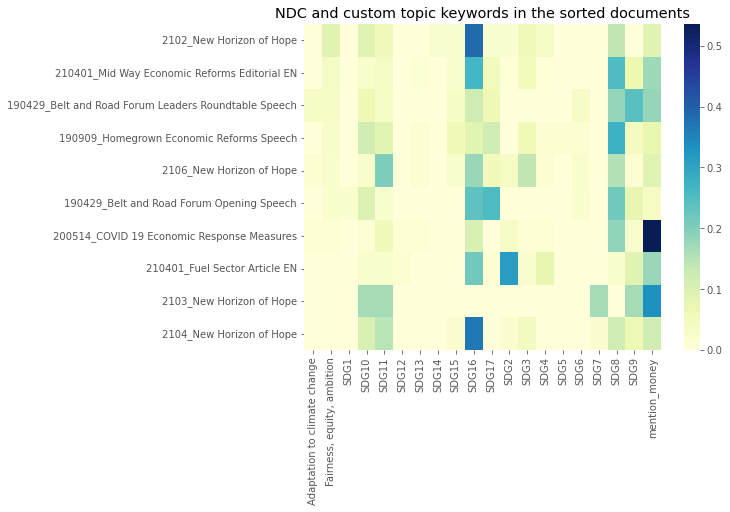

In [171]:
corpus_summary_df = corpus_summary_df.fillna(0)
corpus_summary_df_corr = corpus_summary_df
corpus_summary_df_corr.head()

normed_by_col_sum_corr = corpus_summary_df_corr.div(corpus_summary_df_corr.sum(axis=0), axis=1).round(3)
#sorted_df_corr = normed_by_col_sum_corr.T.sort_values(by=['climate change'], ascending=False)
sorted_df_corr = normed_by_col_sum_corr.T.sort_values(by=['Fairness, equity, ambition'], ascending=False)
normed_by_col_sum_corr.head()

plt.figure(figsize=(8, 6)) #16, 6
ax = sns.heatmap(sorted_df_corr,
                 #annot=True, #fmt="d", 
                 cmap="YlGnBu")
#plt.xlabel("Documents")
#plt.ylabel("Topics")
#ax.yaxis.tick_right()
#ax.yaxis.set_label_position("right")
title = ("NDC and custom topic keywords in the sorted documents")
plt.title(title)
file_name=(title + (' (with correlated NDCs) first 10 docs Ethiopia v3.png'))
plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

In [107]:
corpus_summary_df_corr.index

Index(['SDG1', 'SDG10', 'SDG11', 'SDG12', 'SDG13', 'SDG14', 'SDG15', 'SDG16',
       'SDG17', 'SDG2', 'SDG3', 'SDG4', 'SDG5', 'SDG6', 'SDG7', 'SDG8', 'SDG9',
       'mention_money', 'climate change'],
      dtype='object')

In [146]:
##lets take a look at the document from South Africa used in the example in the proposal first:
#doc_name = '2nd National Biodiversity Strategy Action Plan 2015-2025.txt'
#doc_path = policy_doc_df.loc[doc_name]['policy_doc_paths']

def run_nlp_pipeline_no_lemma(doc_name, doc_path, ndc_dict, max_word_length):
    print(doc_name, doc_path)
    tokens, token_list, sentences = preprocess_doc(doc_path)
    filtered_tokens = filter_tokens(tokens)
    print('These are some of the filtered tokens: ', filtered_tokens[0:10])
    document_text = ' '.join([token.text for token in filtered_tokens if len(token.text)<=max_word_length])
    doc = nlp(document_text)
    ndc_labels, labelled_doc = label_ndc_spans(ndc_dict, doc)
    ndc_idx_df = make_ndc_idx_df_from_spans(ndc_dict, labelled_doc)
    ndc_idx_df.index = ndc_idx_df.NDC.copy()
    ndc_summary_df = ndc_idx_df['NDC'].value_counts().to_frame().rename(columns={"NDC": (doc_name)})
    df_sdg = make_sdg_df(sdg_list, sdg_ontology, document_text)
    doc_summary_sdg = df_sdg.groupby('sdg_topic')['sdg_keywords_num'].sum()
    doc_summary_sdg_df = doc_summary_sdg.to_frame().rename(columns={"sdg_keywords_num": doc_name})
    doc_summary_df = pd.concat([doc_summary_sdg_df, ndc_summary_df]) #combine the SDG and NDC information into one df
    return tokens, token_list, sentences, filtered_tokens, document_text, ndc_idx_df, ndc_summary_df, df_sdg, doc_summary_sdg_df, doc_summary_df #topic_frequencies, sentences

max_word_length=25
corpus_summary_df = pd.DataFrame()
count = 1
for i in range(0, len(policy_doc_df)):
    doc_name = policy_doc_df.iloc[i]['policy_doc_name_clean']
    doc_path = policy_doc_df.iloc[i]['policy_doc_paths']
    tokens, token_list, sentences, filtered_tokens, document_text, ndc_idx_df, ndc_summary_df, df_sdg, doc_summary_sdg_df, doc_summary_df = run_nlp_pipeline_no_lemma(doc_name, doc_path, ndc_dict, max_word_length) 
    print(ndc_idx_df.NDC.value_counts()) 
    if count == 1: 
        corpus_summary_df = doc_summary_df
        total = doc_summary_df[doc_name].sum()
        print(doc_name, len(filtered_tokens), total)
        count += 1
    else: 
        corpus_summary_df_for_merge = doc_summary_df
        total = doc_summary_df[doc_name].sum()
        print(doc_name, len(filtered_tokens), total)
        corpus_summary_df = corpus_summary_df.merge(corpus_summary_df_for_merge, how='outer', left_index=True, right_index=True)
        count += 1
corpus_summary_df.head()  

190909_Homegrown Economic Reforms Speech ../../selected_policy_tracking_docs/Ethiopia/TXT/Website/Other/190909_Homegrown Economic Reforms Speech.txt
These are some of the filtered tokens:  ethiopia new horizon hope distinguished members diplomatic community distinguished development
Fairness, equity, ambition    1
Name: NDC, dtype: int64
190909_Homegrown Economic Reforms Speech 421 68
210401_Fuel Sector Article EN ../../selected_policy_tracking_docs/Ethiopia/TXT/Website/Other/210401_Fuel Sector Article EN.txt
These are some of the filtered tokens:  ethiopia new horizon hope promoting efficiency fuel sector correcting distortions
Series([], Name: NDC, dtype: int64)
210401_Fuel Sector Article EN 509 79
190429_Belt and Road Forum Leaders Roundtable Speech ../../selected_policy_tracking_docs/Ethiopia/TXT/Website/Other/190429_Belt and Road Forum Leaders Roundtable Speech.txt
These are some of the filtered tokens:  ethiopia new horizon hope excellency xi jinping president people republic
Fai

Adaptation to climate change    102
Fairness, equity, ambition       35
Name: NDC, dtype: int64
2010_Agricultural Sector Policy and Investment Framework 13650 3753
2021_10 Year Development Plan ../../selected_policy_tracking_docs/Ethiopia/TXT/Other/2021_10 Year Development Plan.txt
These are some of the filtered tokens:  ethiopia 2030 pathway prosperity years perspective development plan 2021 2030
Fairness, equity, ambition    17
Name: NDC, dtype: int64
2021_10 Year Development Plan 2384 622
2016_National Biodiversity Strategies and Action Plan_ocr ../../selected_policy_tracking_docs/Ethiopia/TXT/Other/2016_National Biodiversity Strategies and Action Plan_ocr.txt
These are some of the filtered tokens:  government federal democratic republic ethiopia sg ethiopia national biodiversyty starate
Adaptation to climate change    351
Fairness, equity, ambition       69
Name: NDC, dtype: int64
2016_National Biodiversity Strategies and Action Plan_ocr 20618 4622
2013_Proclamation 803 ../../selec

,190909_Homegrown Economic Reforms Speech,210401_Fuel Sector Article EN,190429_Belt and Road Forum Leaders Roundtable Speech,200514_COVID 19 Economic Response Measures,190429_Belt and Road Forum Opening Speech,210401_Mid Way Economic Reforms Editorial EN,2103_New Horizon of Hope,2104_New Horizon of Hope,2102_New Horizon of Hope,2106_New Horizon of Hope,...,2016_ANR GTP II,2017_NILUP,2015_GTP II,2016_NNP II,2019_National Adaptation Plan,2010_Agricultural Sector Policy and Investment Framework,2021_10 Year Development Plan,2016_National Biodiversity Strategies and Action Plan_ocr,2013_Proclamation 803,2016_Nutrition Sensitive Agriculture Strategy
Adaptation to climate change,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,...,45,1,48,28,123,102,NaN,351,NaN,10
"Fairness, equity, ambition",1.0,NaN,1.0,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,77,11,280,34,39,35,17.0,69,7.0,18
SDG1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1,3,103,30,16,55,8.0,49,0.0,12
SDG10,8.0,2.0,2.0,1.0,5.0,4.0,1.0,7.0,5.0,2.0,...,298,57,1072,134,147,246,54.0,108,5.0,59
SDG11,6.0,2.0,1.0,5.0,1.0,6.0,1.0,10.0,3.0,16.0,...,746,81,1922,492,316,631,82.0,368,12.0,195


In [148]:
#corpus_summary_df.index
#doc_summary_df
corpus_summary_df = corpus_summary_df.fillna(0)
#output_name = '../../outputs/SA_spacy_matching_NDC_SDGs_df.txt'
#corpus_summary_df.to_csv('../../outputs/SouthAfrica_spacy_matching_NDC_SDGs_corpus_df.txt', sep='\t')

In [166]:
#output_name = '../../outputs/SA_spacy_matching_NDC_SDGs_df.txt'
#corpus_summary_df.to_csv('../../outputs/SouthAfrica_spacy_matching_NDC_SDGs_corpus_df.txt', sep='\t')
#output_name = '../../outputs/Ethiopia_spacy_matching_NDC_SDGs_corpus_df.txt'
#corpus_summary_df.to_csv(output_name, sep='\t')

#output_name = '../../outputs/Ethiopia_corr_matching_NDC_SDGs_10_doc_corpus_df.txt'
#output_name = '../../outputs/SouthAfrica_corr_matching_NDC_SDGs_10_doc_corpus_df.txt'
#corpus_summary_df.to_csv(output_name, sep='\t')

#output_name = '../../outputs/Ethiopia_corr_matching_NDC_SDGs_10_doc_corpus_df.txt'
#corpus_summary_df.to_csv(output_name, sep='\t')

In [137]:
test_df = pd.read_csv('../../outputs/SouthAfrica_spacy_matching_NDC_SDGs_corpus_df.txt', 
                      index_col='Unnamed: 0', sep='\t')
test_df.head()

,InSessionSpecialEditionBudget2021,InSessionVol2Issue10,InSessionVol2Issue11,InSessionSpecialEdition2021,Climate_Change_Bill (2018),Executive Summary-National Development Plan 2030,NGP Framework for public release FINAL_1,South Africa_s Low Emission Development Strategy 2050_ocr,2nd National Biodiversity Strategy Action Plan 2015-2025,National Strategy for Sustainable Development and Action Plan 2011-14_ocr,...,environmentquarterly_jan_march2020,environmentquarterly_october_december2016,environmentquarterly_april_june2017,environmentquarterly_april_june2016,environmentquarterly_october_december2015,environmentquarterly_july_september2018,dea-annual-report-2015-16,dea-annual-report-2018-19,dea-annual-report-2014-15,dea-annual-report-2019-20
SDG1,1.0,6.0,8.0,1.0,0.0,45.0,7.0,17,23,23.0,...,3.0,5.0,3.0,5.0,2.0,20.0,2,2,3,2
SDG10,13.0,36.0,19.0,10.0,25.0,235.0,173.0,175,358,310.0,...,23.0,45.0,59.0,60.0,50.0,53.0,151,134,164,154
SDG11,24.0,59.0,34.0,30.0,36.0,457.0,200.0,292,300,306.0,...,97.0,155.0,145.0,131.0,164.0,192.0,237,277,248,315
SDG12,3.0,7.0,1.0,0.0,0.0,22.0,16.0,131,71,103.0,...,36.0,21.0,182.0,103.0,78.0,61.0,224,338,281,334
SDG13,1.0,1.0,0.0,0.0,405.0,77.0,8.0,1186,137,220.0,...,112.0,98.0,59.0,82.0,289.0,93.0,296,352,299,269


### Make document level heatmaps

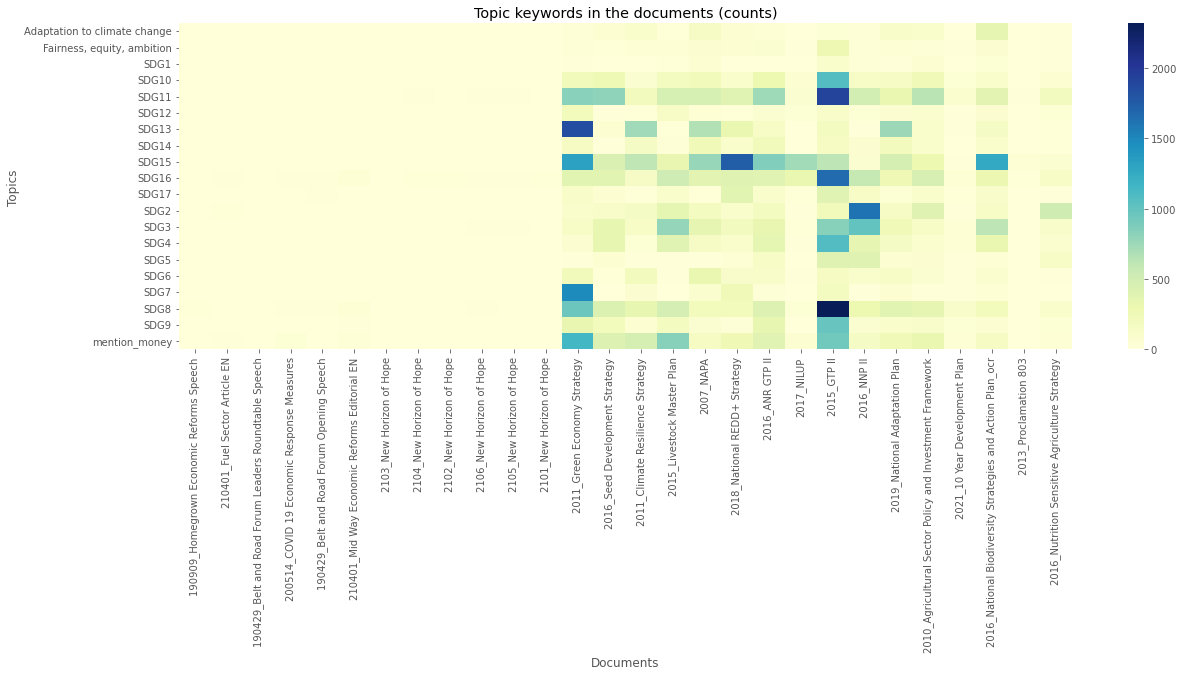

In [151]:
#make heatmap of plot above
plot_folder = '../../outputs/heatmaps/'
plt.figure(figsize=(20, 6)) #16, 6
ax = sns.heatmap(corpus_summary_df,
                 #annot=True, fmt="d", 
                 cmap="YlGnBu")
plt.xlabel("Documents")
plt.ylabel("Topics")
title = ("Topic keywords in the documents (counts)")
plt.title(title)
file_name=(title + (' all docs Ethiopia v1.png'))
plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

In [153]:
corpus_summary_df.index

Index(['Adaptation to climate change', 'Fairness, equity, ambition', 'SDG1',
       'SDG10', 'SDG11', 'SDG12', 'SDG13', 'SDG14', 'SDG15', 'SDG16', 'SDG17',
       'SDG2', 'SDG3', 'SDG4', 'SDG5', 'SDG6', 'SDG7', 'SDG8', 'SDG9',
       'mention_money'],
      dtype='object')

In [154]:
normed_by_col_sum = corpus_summary_df.div(corpus_summary_df.sum(axis=0), axis=1).round(3)
#sorted_df = normed_by_col_sum.T.sort_values(by=['climate change'], ascending=False)
sorted_df = normed_by_col_sum.T.sort_values(by=['Fairness, equity, ambition'], ascending=False)
normed_by_col_sum.head()

#normed_by_col_sum_corr = corpus_summary_df_corr.div(corpus_summary_df_corr.sum(axis=0), axis=1).round(3)
#sorted_df_corr = normed_by_col_sum_corr.T.sort_values(by=['climate change'], ascending=False)
#normed_by_col_sum_corr.head()

,190909_Homegrown Economic Reforms Speech,210401_Fuel Sector Article EN,190429_Belt and Road Forum Leaders Roundtable Speech,200514_COVID 19 Economic Response Measures,190429_Belt and Road Forum Opening Speech,210401_Mid Way Economic Reforms Editorial EN,2103_New Horizon of Hope,2104_New Horizon of Hope,2102_New Horizon of Hope,2106_New Horizon of Hope,...,2016_ANR GTP II,2017_NILUP,2015_GTP II,2016_NNP II,2019_National Adaptation Plan,2010_Agricultural Sector Policy and Investment Framework,2021_10 Year Development Plan,2016_National Biodiversity Strategies and Action Plan_ocr,2013_Proclamation 803,2016_Nutrition Sensitive Agriculture Strategy
Adaptation to climate change,0.000,0.000,0.000,0.010,0.000,0.000,0.000,0.000,0.000,0.013,...,0.009,0.001,0.004,0.005,0.031,0.027,0.000,0.076,0.000,0.006
"Fairness, equity, ambition",0.015,0.000,0.031,0.000,0.038,0.019,0.000,0.000,0.037,0.000,...,0.015,0.008,0.020,0.006,0.010,0.009,0.027,0.015,0.051,0.011
SDG1,0.000,0.000,0.000,0.000,0.019,0.000,0.000,0.000,0.000,0.000,...,0.000,0.002,0.008,0.005,0.004,0.015,0.013,0.011,0.000,0.007
SDG10,0.118,0.025,0.062,0.010,0.096,0.025,0.167,0.103,0.093,0.026,...,0.057,0.039,0.078,0.024,0.037,0.066,0.087,0.023,0.037,0.035
SDG11,0.088,0.025,0.031,0.052,0.019,0.038,0.167,0.147,0.056,0.208,...,0.142,0.056,0.140,0.087,0.079,0.168,0.132,0.080,0.088,0.116


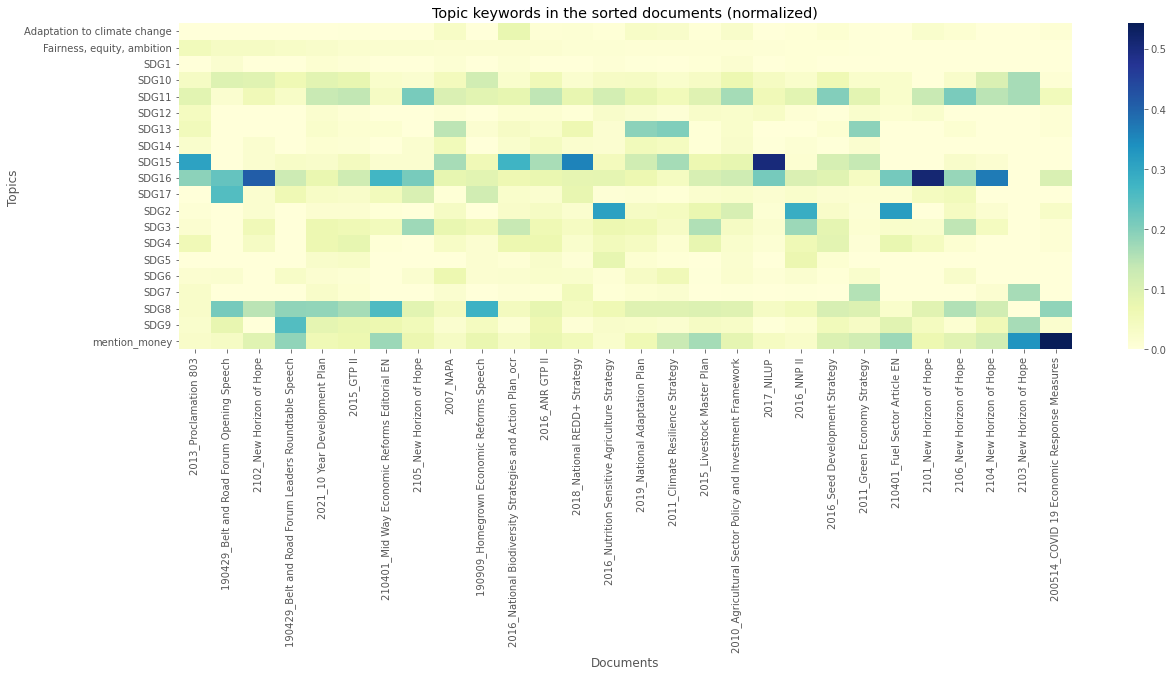

In [156]:
#make heatmap of plot above
plt.figure(figsize=(20, 6)) #16, 6
ax = sns.heatmap(sorted_df.T,
                 #annot=True, #fmt="d", 
                 cmap="YlGnBu")
plt.xlabel("Documents")
plt.ylabel("Topics")
#ax.yaxis.tick_right()
#ax.yaxis.set_label_position("right")
title = ("Topic keywords in the sorted documents (normalized)")
plt.title(title)
file_name=(title + (' all doc Ethiopia v1.png'))
plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

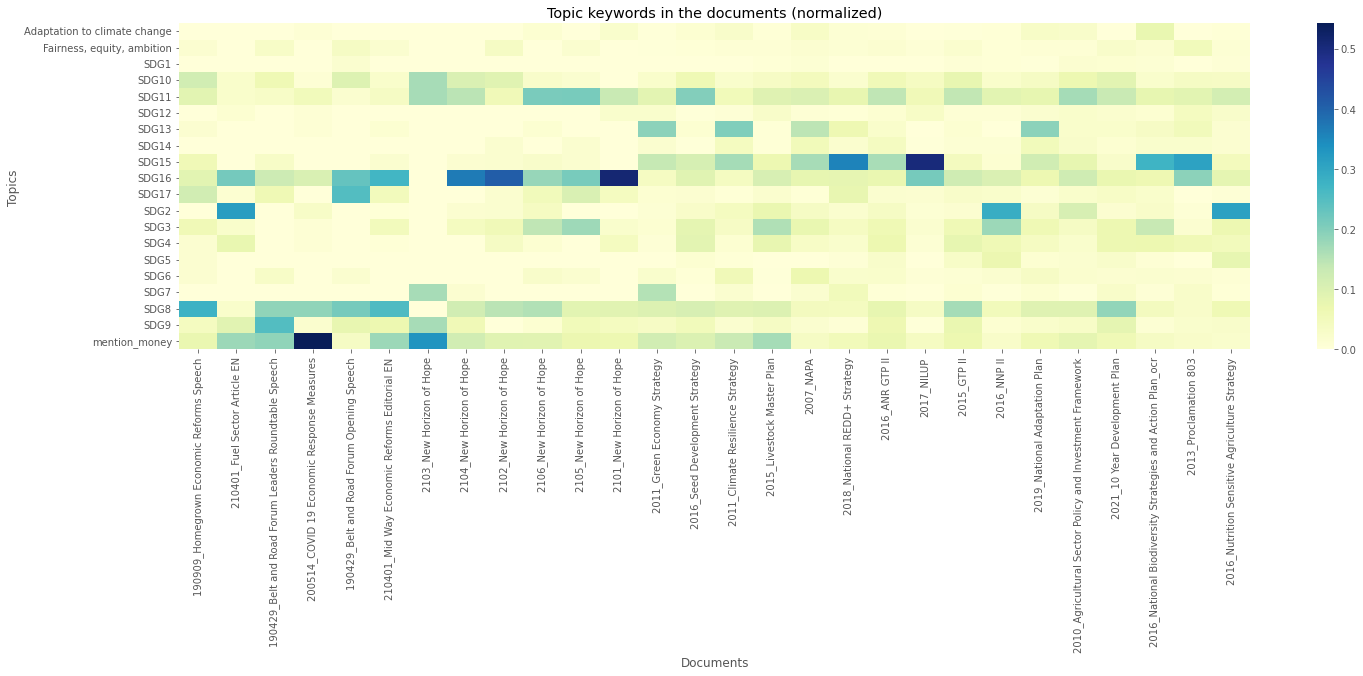

In [157]:
plt.figure(figsize=(24,6)) #16, 6
ax = sns.heatmap(normed_by_col_sum,
                 #annot=True, fmt="d", 
                 cmap="YlGnBu")
plt.xlabel("Documents")
plt.ylabel("Topics")
title = ("Topic keywords in the documents (normalized)")
plt.title(title)
file_name=(title + (' all docs Ethiopia v1.png'))
plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

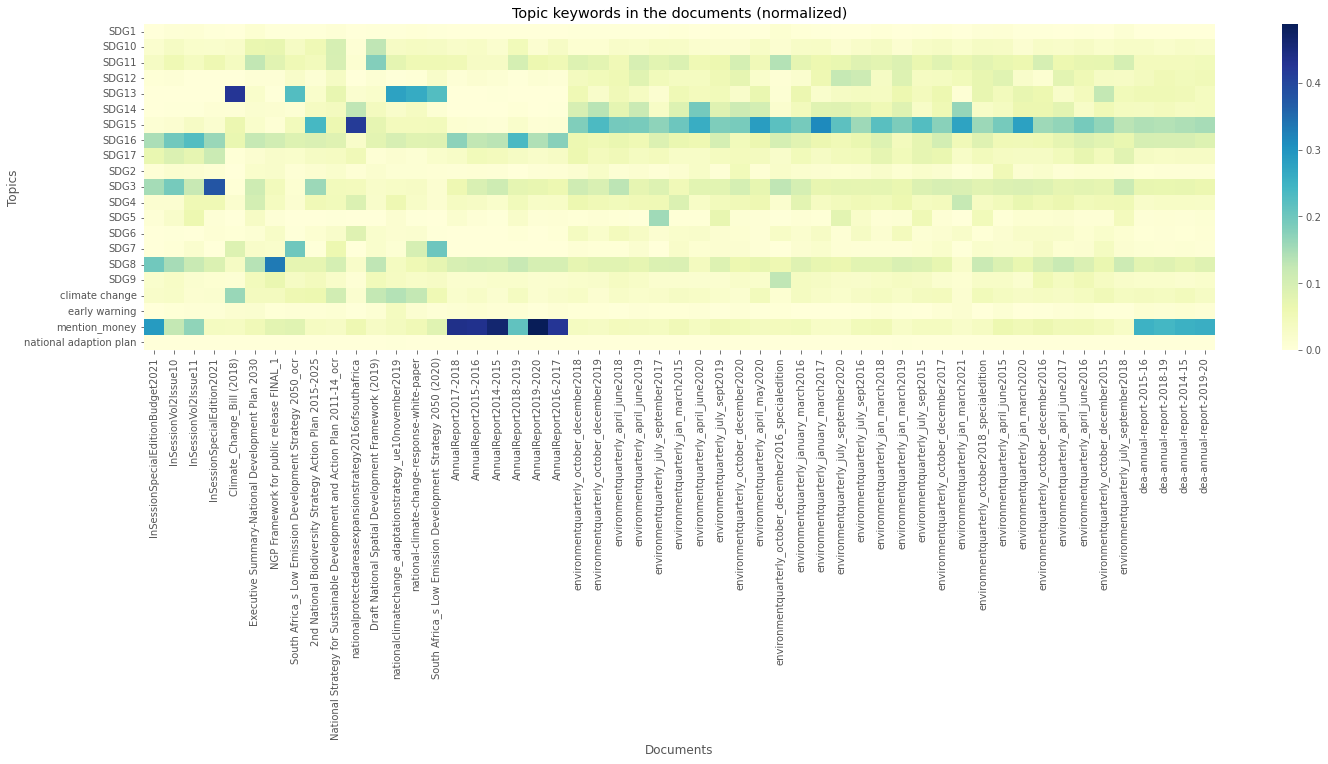

In [128]:
plt.figure(figsize=(24,6)) #16, 6
ax = sns.heatmap(normed_by_col_sum,
                 #annot=True, fmt="d", 
                 cmap="YlGnBu")
plt.xlabel("Documents")
plt.ylabel("Topics")
title = ("Topic keywords in the documents (normalized)")
plt.title(title)
file_name=(title + (' all docs SA v2.png.png'))
plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

<Figure size 432x432 with 0 Axes>

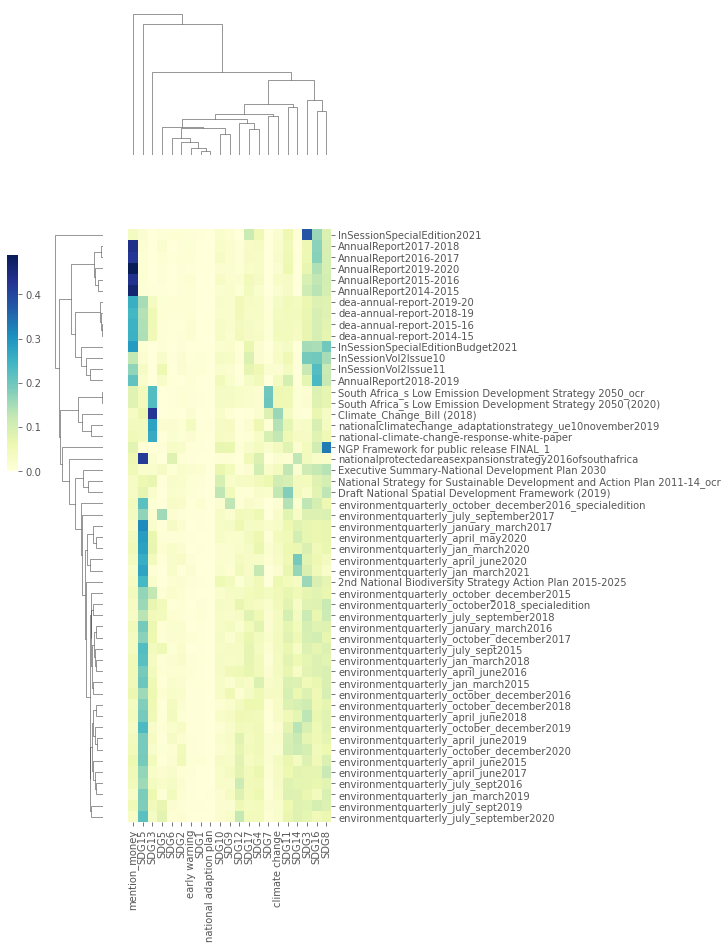

In [135]:
plt.figure(figsize=(6, 6))
ax = sns.clustermap(normed_by_col_sum.T,
                 #annot=True,
                 cbar_pos=(0, .45, .03, .2),
                 cmap="YlGnBu", 
                 xticklabels=1, 
                 yticklabels=1, 
                 figsize=(5, 15))
#plt.xlabel("Documents")
#plt.ylabel("SDG Topics")
title = ("Distribution of topic keywords in the documents (normalized)")
#plt.title(title)
file_name=(title + (' clustermap all docs SA v2.png'))
plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

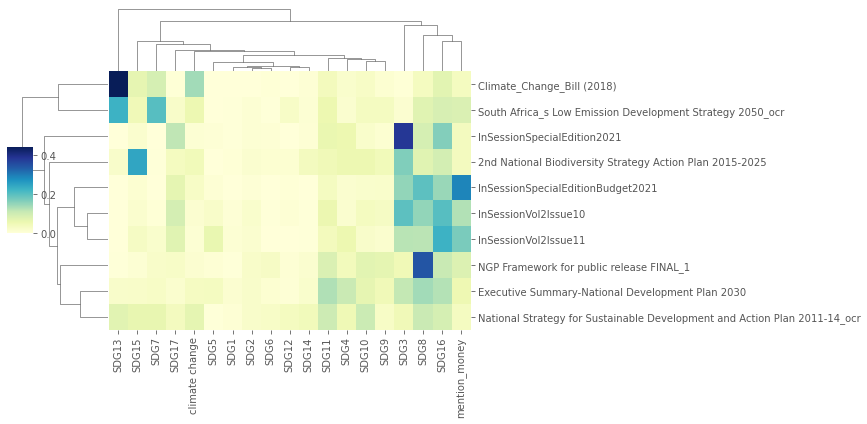

In [96]:
ax = sns.clustermap(normed_by_col_sum_corr.T,
                 #annot=True,
                 cbar_pos=(0, .45, .03, .2),
                 cmap="YlGnBu", 
                 xticklabels=1, 
                 figsize=(12, 6))
#plt.xlabel("Documents")
#plt.ylabel("SDG Topics")
title = ("Distribution of topic keywords (with correlated NDC words) in the documents (normalized)")
#plt.title(title)
file_name=(title + (' clustermap 10 docs SA v2.png'))
plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

In [210]:
#if using Johnathan's fuzzy search:
doc_name = '2nd National Biodiversity Strategy Action Plan 2015-2025.txt' #'Climate_Change_Bill (2018).txt' 
doc_path = policy_doc_df.loc[doc_name]['policy_doc_paths']

def run_nlp_pipeline_no_lemma_ndc_corr(doc_name, doc_path, ndc_dict, max_word_length):
    print(doc_name, doc_path)
    tokens, token_list, sentences = preprocess_doc(doc_path)
    filtered_tokens = filter_tokens(tokens)
    print('These are some of the filtered tokens: ', filtered_tokens[0:10])
    document_text = ' '.join([token.text for token in filtered_tokens if len(token.text)<=max_word_length])
    doc = nlp(document_text)
    ndc_labels, ndc_dict_corr, labelled_doc = label_ndc_spans_correlated(ndc_dict, doc, span_length=2, corr_thresh=0.7)
    ndc_idx_df = make_ndc_idx_df_from_spans(ndc_dict_corr, labelled_doc)
    ndc_idx_df.index = ndc_idx_df.NDC.copy()
    ndc_summary_df = ndc_idx_df['NDC'].value_counts().to_frame().rename(columns={"NDC": (doc_name)})
    df_sdg = make_sdg_df(sdg_list, sdg_ontology, document_text)
    doc_summary_sdg = df_sdg.groupby('sdg_topic')['sdg_keywords_num'].sum()
    doc_summary_sdg_df = doc_summary_sdg.to_frame().rename(columns={"sdg_keywords_num": doc_name})
    doc_summary_df = pd.concat([doc_summary_sdg_df, ndc_summary_df]) #combine the SDG and NDC information into one df
    return tokens, token_list, sentences, filtered_tokens, document_text, ndc_dict_corr, ndc_idx_df, ndc_summary_df, df_sdg, doc_summary_sdg_df, doc_summary_df #topic_frequencies, sentences

max_word_length=25
tokens, token_list, sentences, filtered_tokens, document_text, ndc_dict_corr, ndc_idx_df, ndc_summary_df, df_sdg, doc_summary_sdg_df, doc_summary_df = run_nlp_pipeline_no_lemma_ndc_corr(doc_name, doc_path, ndc_dict, max_word_length) 
print(ndc_idx_df.NDC.value_counts()) 
total = doc_summary_df[doc_name].sum()
print(doc_name, len(filtered_tokens), total)
#output_name = '../../outputs/SA_corr_matching_NDC_SDGs_climate_change_bill_2018_df.txt'
#corpus_summary_df.to_csv(output_name, sep='\t')
ndc_dict_corr

2nd National Biodiversity Strategy Action Plan 2015-2025.txt ../../selected_policy_tracking_docs/SouthAfrica/Non-Regular Documents after 2015 SDSN Suggested/TXT/2nd National Biodiversity Strategy Action Plan 2015-2025.txt
These are some of the filtered tokens:  south africa 2 nd national biodiversity strategy action plan 2015
34 23
296 95
37 23
climate change            286
early warning              37
national adaption plan     34
Name: NDC, dtype: int64
2nd National Biodiversity Strategy Action Plan 2015-2025.txt 24762 6582


{'national adaption plan': ['sector establish',
  'sector body',
  'sector culminated',
  'sector range',
  'plan nap',
  'sector given',
  'sector \uf0b7',
  'sector parastatals',
  'adaptation sanbi',
  'sector drdlr',
  'national planning',
  'sector plans',
  'national adaptation',
  'sanbi sector',
  'plan national',
  'programme nap',
  'sector based',
  'nap national',
  'sector place',
  'adaptation plans',
  'sector established',
  'sector going',
  'high47 sector'],
 'climate change': ['leading development',
  'enhance resilience',
  'development decision',
  'development national',
  'land uses',
  'development demonstrate',
  'development authorisations',
  'development programmes',
  'development community',
  'development programme',
  'development concept',
  'development nation',
  'development gaylard',
  'underpin development',
  'development plan',
  'development systems',
  'development face',
  'development significant',
  'recordal system',
  'resulted development

In [219]:
window_tokens_overall = tokens
window_size = 200
ndc_climate_idxs = list(ndc_idx_df[ndc_idx_df['NDC']=='climate change']['word_index'])
idx_for_window = ndc_climate_idxs
idx_for_window = filter_idx_for_overlap(idxs=ndc_climate_idxs, min_dist=50)

count = 0
for index in idx_for_window[0:len(idx_for_window)]:
    count += 1
    print(index)
    window_tokens = return_window(index, window_tokens_overall, size=window_size)[2]
    window_text = ' '.join([token.text for token in window_tokens])
    #print(window_text)
    df_sdg = make_sdg_df(sdg_list, sdg_ontology, window_text) #may want to keep this for the windows for a more granular analysis
    df_sdg_sorted = df_sdg.sort_values(by=['sdg_keywords_num'], ascending=False)
    #print(df_sdg_sorted.head())
    print(list(df_sdg_sorted[df_sdg_sorted['sdg_keywords_num'] > 0]['sdg_keywords'][:10])) #print top 10 positive valued keywords
    #print a summary of the SDG words found: 
    summary_sdg = df_sdg.groupby('sdg_topic')['sdg_keywords_num'].sum()
    if count == 1: 
        summary_sdg_df = summary_sdg.to_frame().rename(columns={"sdg_keywords_num": ("sdg_kw_%d"% index)})
    else: 
        summary_sdg_df_for_merge = summary_sdg.to_frame().rename(columns={"sdg_keywords_num": ("sdg_kw_%d"% index)})
        summary_sdg_df = summary_sdg_df.merge(summary_sdg_df_for_merge, left_index=True, right_index=True)
summary_sdg_df

[8, 119, 11, 225, 29, 52, 138, 20, 5, 58, 17, 87, 17, 25, 26, 47, 58, 26, 14, 79]
The number of times the idx words were found was:  286 
 The number of idx words seperated by at least the min_distance was :  115
40
['diversity', '$']
170
['diversity', '$', 'fund']
424
['diversity', '$', 'fund']
476
['diversity', '$']
639
['diversity', '$']
714
['$']
916
['$']
1014
['$']
1166
['$']
1291
['$']
1370
['$']
1435
['$']
1503
['$']
1638
['$', 'policy']
1715
['diversity', 'policy', '$']
1857
['policies', 'diversity', 'development policies', '$', 'government', 'policy', 'development']
1915
['policies', 'diversity', 'development policies', '$', 'government', 'policy', 'development']
2097
['diversity', 'biodiversity', 'policies', '$', 'development policies', 'government', 'development']
2227
['diversity', 'biodiversity', 'government', '$', 'work']
2729
['rural', 'rural development', '$', 'biodiversity', 'job creation', 'economy', 'development', 'rural development', 'wellbeing', 'diversity']
2971


,sdg_kw_40,sdg_kw_170,sdg_kw_424,sdg_kw_476,sdg_kw_639,sdg_kw_714,sdg_kw_916,sdg_kw_1014,sdg_kw_1166,sdg_kw_1291,...,sdg_kw_21417,sdg_kw_21526,sdg_kw_21770,sdg_kw_22379,sdg_kw_22472,sdg_kw_22575,sdg_kw_22719,sdg_kw_23262,sdg_kw_24227,sdg_kw_24405
sdg_topic,,,,,,,,,,,,,,,,,,,,,
SDG1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SDG10,0,0,0,0,0,0,0,0,0,0,...,4,4,3,2,2,1,0,0,1,1
SDG11,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
SDG12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SDG13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SDG14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SDG15,0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,1,1,1,0,1,0
SDG16,0,0,0,0,0,0,0,0,0,0,...,0,0,1,2,2,1,0,0,0,0
SDG17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


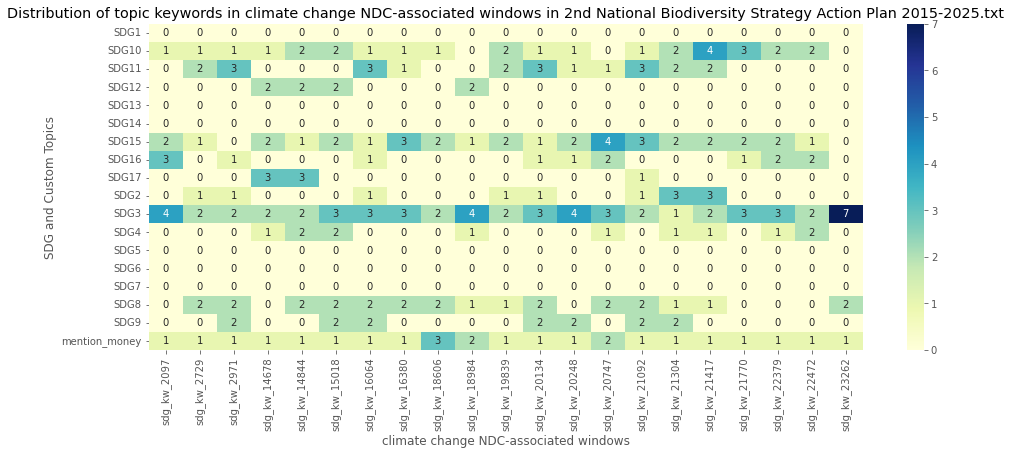

In [220]:
summary_sdg_df_filtered = summary_sdg_df.loc[:, (summary_sdg_df.sum() >= 10)]
#make heatmap of plot above
plt.figure(figsize=(16, 6))
ax = sns.heatmap(summary_sdg_df_filtered,
                 annot=True, #fmt="d", 
                 cmap="YlGnBu")
plt.xlabel("climate change NDC-associated windows")
plt.ylabel("SDG and Custom Topics")
title = ("Distribution of topic keywords in climate change NDC-associated windows in %s" % (doc_name))
plt.title(title)
file_name=(title + (' across windows from corr matching and above 10 topic words.png'))
plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

In [223]:
#print(ndc_idx_df[ndc_idx_df['word_index']==23262])
#index=2875
#index=9693
index=23262
print(ndc_idx_df[ndc_idx_df['word_index']==index])
print(return_window(index, tokens, size=window_size)[2]) #print(window_tokens[2])
summary_sdg_df[('sdg_kw_%d' % index)]
test_text = return_window(index, window_tokens_overall, size=window_size)[2]
test_text

                           NDC                  word  word_index
NDC                                                             
climate change  climate change  development planning       23262
practitioners 6.5 Knowledge base is accessible and presented in a way that informs decisionmaking ( 21 activities ) ( 8 activities ) ( 37 activities ) ( 7 activities ) ( 12 activities ) ( 29 activities)1 Introduction The National Biodiversity Strategy and Action Plan ( NBSAP ) is a requirement that contracting parties to the Convention on Biological Diversity ( CBD ) are obligated to fulfil . An NBSAP sets out an


practitioners 6.5 Knowledge base is accessible and presented in a way that informs decisionmaking ( 21 activities ) ( 8 activities ) ( 37 activities ) ( 7 activities ) ( 12 activities ) ( 29 activities)1 Introduction The National Biodiversity Strategy and Action Plan ( NBSAP ) is a requirement that contracting parties to the Convention on Biological Diversity ( CBD ) are obligated to fulfil . An NBSAP sets out an

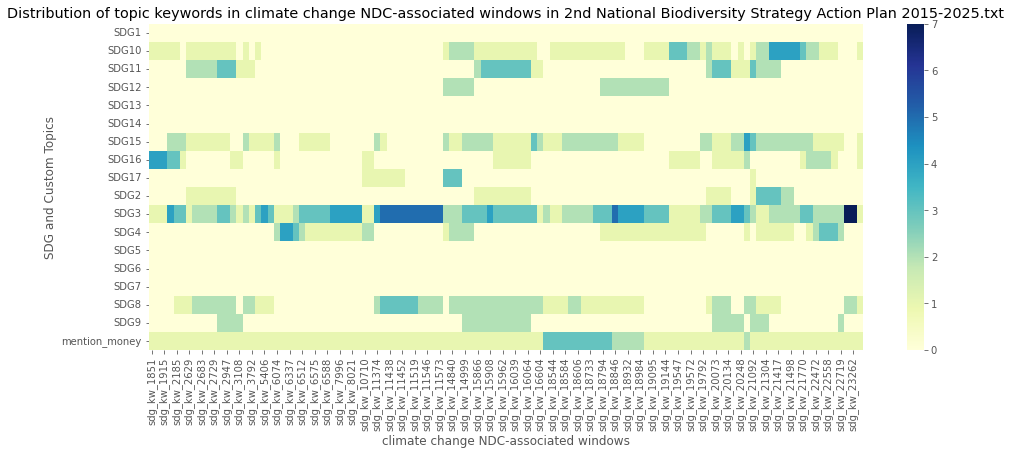

In [217]:
#make heatmap of plot above
summary_sdg_df_filtered = summary_sdg_df.loc[:, (summary_sdg_df.sum() >= 6)]
plt.figure(figsize=(16, 6))
ax = sns.heatmap(summary_sdg_df_filtered,
                 #annot=True, #fmt="d", 
                 cmap="YlGnBu")
plt.xlabel("climate change NDC-associated windows")
plt.ylabel("SDG and Custom Topics")
title = ("Distribution of topic keywords in climate change NDC-associated windows in %s" % (doc_name))
plt.title(title)
file_name=(title + (' across windows from corr matching and above 6 topic words.png'))
plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

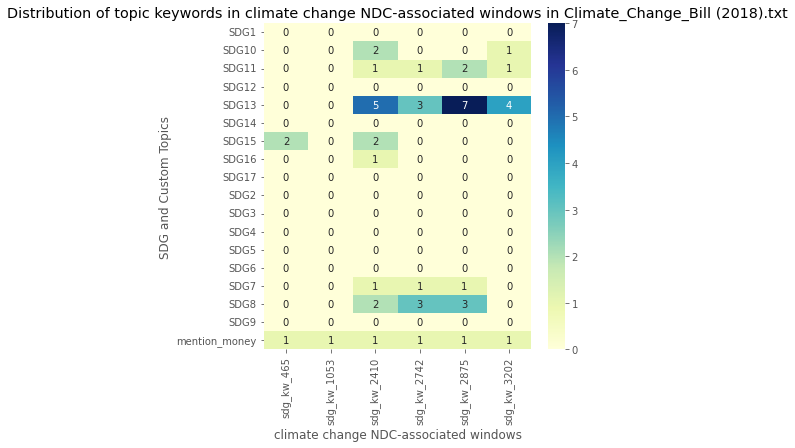

In [200]:
#make heatmap of plot above
plt.figure(figsize=(6, 6))
ax = sns.heatmap(summary_sdg_df,
                 annot=True, #fmt="d", 
                 cmap="YlGnBu")
plt.xlabel("climate change NDC-associated windows")
plt.ylabel("SDG and Custom Topics")
title = ("Distribution of topic keywords in climate change NDC-associated windows in %s" % (doc_name))
plt.title(title)
file_name=(title + (' across windows from corr matching.png'))
plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

In [203]:
#index=79
#index=2675
print(ndc_idx_df[ndc_idx_df['word_index']==2875])
index=2875
#index=9693
print(return_window(index, window_tokens_overall, size=window_size)[2]) #print(window_tokens[2])
summary_sdg_df[('sdg_kw_%d' % index)]
test_text = return_window(index, window_tokens_overall, size=window_size)[2]
test_text

                           NDC            word  word_index
NDC                                                       
climate change  climate change  budget provide        2875
a just transition to a climate resilient , equitable and internationally competitive lower carbon economy and society , that takes into account the economic , employment and societal risks and opportunities that are expected to arise as a consequence of implementing the national climate change response ; AND WHEREAS anticipated domestic climate change impacts have the potential to undermine many


a just transition to a climate resilient , equitable and internationally competitive lower carbon economy and society , that takes into account the economic , employment and societal risks and opportunities that are expected to arise as a consequence of implementing the national climate change response ; AND WHEREAS anticipated domestic climate change impacts have the potential to undermine many

In [ ]:
ndc

In [ ]:
def label_ndc_sdg_spans_in_windows(ndc_keywords, doc):
    """ndc_keywords is a dictionary, doc is the document text with nlp run on it that is the filtered but not lemmatized document text."""
    matcher = PhraseMatcher(nlp.vocab)
    #iterate through NDC keys in NDC dictionary to create seperate label categories for the matching
    entity_labels = []
    for entity_reference in [key for key in ndc_keywords.keys()]:
        entity_label = entity_reference + ' NDC'
        #print(entity_label)
        entity_labels.append(entity_label)
        keywords = ndc_keywords[entity_reference]
        patterns = [nlp(i) for i in keywords]
        #print(keywords, patterns)
        matcher.add(entity_label, None, *patterns)
    matches = matcher(doc)
        #label spans
    for match_id, start, end in matches:
        try:
            span = Span(doc, start, end, label=match_id)
            doc.ents = list(doc.ents) + [span]  # add span to doc.ents
        except: 
            pass
    #print([(ent.text, ent.start, ent.label_) for ent in doc.ents])
    return entity_labels, doc

In [ ]:
ndc_idx_df.NDC.value_counts()#head()

In [ ]:
#look at SDGs across document/at document level
max_length=25
document_text = ' '.join([token.text for token in tokens if len(token.text)<=max_length])

df_sdg = make_sdg_df(sdg_list, sdg_ontology, document_text)
doc_summary_sdg = df_sdg.groupby('sdg_topic')['sdg_keywords_num'].sum()
doc_summary_sdg_df = doc_summary_sdg.to_frame().rename(columns={"sdg_keywords_num": ("%s"% doc_name)})
doc_summary_sdg_df 

#lets see the 50 words that occur the most often
df_sdg.sort_values(by=['sdg_keywords_num'], ascending=False)[:50]

In [ ]:
total = doc_summary_sdg_df[doc_name].sum()
print(doc_name, len(filtered_tokens), total)

### Apply Jonathan's fuzzy search method to find NDC related words

In [42]:
#sample to work with 
doc_name = '2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt'
doc_path = policy_doc_df.loc[doc_name]['policy_doc_paths']

def run_nlp_pipeline_no_lemma(doc_name, doc_path, ndc_dict, max_word_length):
    print(doc_name, doc_path)
    tokens, token_list, sentences = preprocess_doc(doc_path)
    filtered_tokens = filter_tokens(tokens)
    print('These are some of the filtered tokens: ', filtered_tokens[0:10])
    document_text = ' '.join([token.text for token in filtered_tokens if len(token.text)<=max_word_length])
    doc = nlp(document_text)
    ndc_labels, labelled_doc = label_ndc_spans(ndc_dict, doc)
    ndc_idx_df = make_ndc_idx_df_from_spans(ndc_dict, labelled_doc)
    ndc_idx_df.index = ndc_idx_df.NDC.copy()
    ndc_summary_df = ndc_idx_df['NDC'].value_counts().to_frame().rename(columns={"NDC": (doc_name)})
    df_sdg = make_sdg_df(sdg_list, sdg_ontology, document_text)
    doc_summary_sdg = df_sdg.groupby('sdg_topic')['sdg_keywords_num'].sum()
    doc_summary_sdg_df = doc_summary_sdg.to_frame().rename(columns={"sdg_keywords_num": doc_name})
    doc_summary_df = pd.concat([summary_sdg_df_doc, ndc_summary_df]) #combine the SDG and NDC information into one df
    return tokens, token_list, sentences, filtered_tokens, document_text, ndc_idx_df, df_sdg, doc_summary_df #topic_frequencies, sentences

#other cool, more detailed outputs (perhaps for future knowledge graphs): 
#df_sdg, ndc_idx_df

count=1
max_word_length=25
tokens, token_list, sentences, filtered_tokens, document_text, ndc_idx_df, df_sdg, doc_summary_df = run_nlp_pipeline_no_lemma(doc_name, doc_path, ndc_dict, max_word_length)   
print(ndc_idx_df.NDC.value_counts())
if count == 1: 
    corpus_summary_df = doc_summary_df
    total = corpus_summary_df[doc_name].sum()
    print(doc_name, len(filtered_tokens), total)
else: 
    corpus_summary_df_for_merge = doc_summary_df
    total = corpus_summary_df_for_merge[doc_name].sum()
    print(doc_name, len(filtered_tokens), total)
    corpus_summary_df = corpus_summary_df.merge(corpus_summary_df_for_merge, left_index=True, right_index=True)
    count += 1
corpus_summary_df.head() 

2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt ../../policy_tracking_docs/SouthAfrica/Data/Non-Regular Documents after 2015 SDSN Suggested/TXT/2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt
These are some of the filtered tokens:  environmental affairs department environmental affairs republic south africa y south
climate change            408
early warning              71
national adaption plan      3
Name: NDC, dtype: int64
2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt 25442 6677


,2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt
SDG1,23
SDG10,360
SDG11,294
SDG12,69
SDG13,134


In [64]:
def label_ndc_spans_correlated(ndc_keywords, doc, span_length=2, corr_thresh=0.7):
    """ndc_keywords is a dictionary, doc is the document text with nlp run on it that is the filtered but not lemmatized document text."""
    matcher = PhraseMatcher(nlp.vocab)
    #iterate through NDC keys in NDC dictionary to create seperate label categories for the matching
    entity_labels = []
    for entity_reference in [key for key in ndc_keywords.keys()]:
        entity_label = entity_reference + ' NDC'
        #print(entity_label)
        entity_labels.append(entity_label)
        keywords = ndc_keywords[entity_reference]
        n_gram_cor = NGramCorrelateSpacy(keywords, corr_thresh, entity_label)
        doc.ents = []
        n_gram_cor.correlate_spans(doc, span_length)
        print(len(doc.ents), len(set([ent.text for ent in list(doc.ents)])))
        unique_keywords_from_corr = set([ent.text for ent in list(doc.ents)])
        patterns = [nlp(i) for i in unique_keywords_from_corr]
        #print(keywords, patterns)
        matcher.add(entity_label, None, *patterns)
    matches = matcher(doc)
        #label spans
    for match_id, start, end in matches:
        try:
            span = Span(doc, start, end, label=match_id)
            doc.ents = list(doc.ents) + [span]  # add span to doc.ents
        except: 
            pass
    print([(ent.text, ent.start, ent.label_) for ent in doc.ents])
    return entity_labels, doc

In [66]:
document_text
doc = nlp(document_text)
entity_labels, new_doc = label_ndc_spans_correlated(ndc_dict, doc, span_length=2, corr_thresh=0.7)

10 6
115 58
33 28
[('development plan', 3, 'climate change NDC'), ('national planning', 10, 'national adaption plan NDC'), ('development plan', 14, 'climate change NDC'), ('development plan', 163, 'climate change NDC'), ('development plan', 315, 'climate change NDC'), ('development plan', 482, 'climate change NDC'), ('development plan', 665, 'climate change NDC'), ('¢ respond', 673, 'climate change NDC'), ('development plan', 827, 'climate change NDC'), ('development plan', 955, 'climate change NDC'), ('development plan', 993, 'climate change NDC'), ('development programme', 1280, 'climate change NDC'), ('development plan', 1284, 'climate change NDC'), ('national planning', 1291, 'national adaption plan NDC'), ('development plan', 1298, 'climate change NDC'), ('development 5', 1361, 'climate change NDC'), ('system meet', 1370, 'early warning NDC'), ('national plan', 1403, 'national adaption plan NDC'), ('development plan', 1478, 'climate change NDC'), ('development progress', 1490, 'cl

In [ ]:
document_text[100:200]

In [ ]:
from correlation import *
from textutils import importer

##lets take a look at the document from South Africa used in the example in the proposal first:
doc_name = '2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt'
doc_path = policy_doc_df.loc[doc_name]['policy_doc_paths']

annual_report = importer.TextImporter(doc_path)
with open("../ndc_keywords/ndc_south_africa.json") as f:
    ndc_keywords = json.load(f)

climate_keywords = ndc_keywords['climate change']
#climate_keywords = list(sdg_ontology[sdg_ontology['clasification']=='SDG13']['keyword'])
doc = nlp(document_text) #modified to use filtered version of text #nlp(annual_report.text)

In [ ]:
#sdg_ontology[sdg_ontology['clasification']=='SDG13']
climate_keywords

In [ ]:
from n_gram_correlation import NGramCorrelateSpacy
n_gram_cor = NGramCorrelateSpacy(climate_keywords, 0.7, "CLIMATE_N")
doc.ents = []
n_gram_cor.correlate_spans(doc, 2)
print(len(doc.ents))

In [ ]:
for e in doc.ents[0:10]:
    displacy.render(doc[e.start-20:e.end+20], style='ent')

In [ ]:
print(doc.ents[:20])
#idx = [ent.start for ent in doc.ents]
ndc_climate_idxs = [ent.start for ent in doc.ents]
print(len(ndc_climate_idxs))

In [ ]:
token_correlator = TokenArrayCorrelator(climate_keywords, 0.4, "CLIMATE_TOKEN")
span_correlator = SpanCorrelator(climate_keywords, 0.4, "CLIMATE_SPAN")
generic_correlator = KeywordCorrelator(climate_keywords)

sentence_to_correlate = "We need to adapt our project to be more resillient to geographical circumstances."
unrelated_sentence = "The next time the leaders will meet in paris"

#print(generic_correlator([sent for sent in sentences]))

In [ ]:
ndc_keywords

In [21]:
def label_ndc_spans(ndc_keywords, doc):
    """ndc_keywords is a dictionary, doc is the document text with nlp run on it that is the filtered but not lemmatized document text."""
    matcher = PhraseMatcher(nlp.vocab)
    #iterate through NDC keys in NDC dictionary to create seperate label categories for the matching
    entity_labels = []
    for entity_reference in [key for key in ndc_keywords.keys()]:
        entity_label = entity_reference + ' NDC'
        print(entity_label)
        entity_labels.append(entity_label)
        keywords = ndc_keywords[entity_reference]
        patterns = [nlp(i) for i in keywords]
        #print(keywords, patterns)
        matcher.add(entity_label, None, *patterns)
    matches = matcher(doc)
        #label spans
    for match_id, start, end in matches:
        try:
            span = Span(doc, start, end, label=match_id)
            doc.ents = list(doc.ents) + [span]  # add span to doc.ents
        except: 
            pass
    #print([(ent.text, ent.start, ent.label_) for ent in doc.ents])
    return entity_labels, doc

test_text = document_text #"natural nationa ationa organisi association of conservancies of south africa action plan biodiversity assessment biodiversity and business network biodiversity economy strategy biodiversity framework biodiversity strategy and action plan rimental finding development plan department of tourism environmental advisory forum environmental management act environmental skills planning forum implementing"
test_doc = nlp(test_text)
ndc_labels, labelled_doc = label_ndc_spans(ndc_dict, test_doc)
ndc_idx_df = make_ndc_idx_df_from_spans(ndc_dict, labelled_doc)
#displacy.render(labelled_doc, style = "ent", jupyter = True)
#labelled_doc.ents

national adaption plan NDC
climate change NDC
early warning NDC


In [28]:


ndc_idx_df = make_ndc_idx_df_from_spans(ndc_dict, labelled_doc)
ndc_idx_df 

national adaption plan NDC
climate change NDC
early warning NDC


,NDC,word,word_index
0,national adaption plan,nap,985
1,national adaption plan,nap,4306
2,national adaption plan,nap,15582
0,climate change,development,98
1,climate change,development,134
...,...,...,...
66,early warning,system,23339
67,early warning,system,24043
68,early warning,system,24290
69,early warning,system,24745


In [ ]:
if count == 1: 
    summary_sdg_df_doc = doc_summary_sdg_df
    total = doc_summary_sdg_df[doc_name].sum()
    print(doc_name, len(filtered_tokens), total)
else: 
    summary_sdg_df_doc_for_merge = doc_summary_sdg_df
    total = summary_sdg_df_doc_for_merge[doc_name].sum()
    print(doc_name, len(filtered_tokens), total)
    summary_sdg_df_doc = summary_sdg_df_doc.merge(summary_sdg_df_doc_for_merge, left_index=True, right_index=True)
    count += 1

In [ ]:
test_text = "helps to address poverty and unemployment . operation phakisa is initially implemented in two sectors , the ocean economy and health , and will be rolled out in other sectors . in the oceans economy four priority areas for unlocking the oceans economy through inclusive economic growth have been identified , one of which is marine protection services and ocean governance . other biodiversity and"
sdg_ontology[sdg_ontology['clasification']=='SDG8']['keyword']
#list(ndc_dict['climate change'])

def label_ndc_spans_return_index(entity_reference, ndc_keywords, document_text):
    """ndc_keywords is a dictionary, document_text is the filtered but not lemmatized document text."""
    entity_label = entity_reference + ' NDC'
    keywords = ndc_keywords[entity_reference]
    patterns = [nlp(i) for i in keywords]
    matcher = PhraseMatcher(nlp.vocab)
    matcher.add(entity_label, None, *patterns)
    doc = nlp(document_text)
    matches = matcher(doc)
    #label spans
    for match_id, start, end in matches:
        try:
            span = Span(doc, start, end, label=match_id)
            doc.ents = list(doc.ents) + [span]  # add span to doc.ents
        except: 
            pass
    #get list of spans related to the ndc
    idxs_from_matcher = [ent.start for ent in doc.ents if ent.label_ == entity_label]
    return doc, idxs_from_matcher
    
entity_reference = 'climate change'
#print([(ent.text, ent.start, ent.label_) for ent in doc.ents]) #there are some cool default entitites as well
climate_ndc_idxs_from_matcher = label_ndc_spans_return_index(entity_reference, ndc_keywords, document_text)[1]
climate_ndc_idxs_from_matcher

new_doc = label_ndc_spans_return_index(entity_reference, ndc_keywords, document_text)[0]

In [ ]:
#lets make another function to label categories:

def label_keywords(entity_reference, keyword_list, text):
    """ndc_keywords is a dictionary, document_text is the filtered but not lemmatized document text."""
    entity_label = entity_reference
    patterns = [nlp(i) for i in keyword_list]
    matcher = PhraseMatcher(nlp.vocab)
    matcher.add(entity_label, None, *patterns)
    doc = nlp(document_text)
    matches = matcher(doc)
    #label spans
    for match_id, start, end in matches:
        try:
            span = Span(doc, start, end, label=match_id)
            doc.ents = list(doc.ents) + [span]  # add span to doc.ents
        except: 
            pass
    #get list of spans related to the ndc
    idxs_from_matcher = [ent.start for ent in doc.ents if ent.label_ == entity_label]
    return doc, idxs_from_matcher

sdg_list = ['SDG1', 'SDG2', 'SDG3', 'SDG4', 'SDG5', 'SDG6', 'SDG7', 'SDG8', 'SDG9', 
            'SDG10', 'SDG11', 'SDG12', 'SDG13', 'SDG14', 'SDG15', 'SDG16', 'SDG17', 
            "mention_money"]

index=361
index=5868
index=9693
print(return_window(index, window_tokens_overall, size=window_size)[2]) #print(window_tokens[2])
summary_sdg_df[('sdg_kw_%d' % index)]

test_text = return_window(index, window_tokens_overall, size=window_size)[2]
test_text

text = test_text
sdg_list = ['SDG15']
for i in sdg_list:
    entity_reference = i
    keyword_list = list(sdg_ontology[sdg_ontology['clasification']==entity_reference]['keyword'])
    text = label_keywords(entity_reference, keyword_list, text)[0]

In [ ]:
from spacy import displacy
colors = {"climate change NDC" :'#3A9C75', 
          "SDG3": "#3A619C"
          "SDG14": "#85C1E9", 
          "SDG8": "#ff6961", 
          "SDG15": "#3A619C"}
#colors = {"SDG14": "#85C1E9", "SDG8": "#ff6961"}
options = {"ents": ['SDG14', 'SDG8', "SDG15"], "colors": colors}
displacy.render(doc, style='ent', options=options) 

In [ ]:
#lets see if we can find ndc phrases with spacy matcher
#document_text

keywords = list(ndc_keyword_dict['climate cha'])
sdg14_keywords = list(sdg_ontology[sdg_ontology['clasification']=='SDG14']['keyword'])
sdg8_keywords = list(sdg_ontology[sdg_ontology['clasification']=='SDG8']['keyword'])

patterns14 = [nlp(i) for i in sdg14_keywords]
patterns8 = [nlp(i) for i in sdg8_keywords]
matcher = PhraseMatcher(nlp.vocab)
matcher.add('SDG14', None, *patterns14)
matcher.add('SDG8', None, *patterns8)


In [ ]:
#ndc_climate_idxs
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span

good = ['bacon', 'chicken', 'lamb','hot dog']
bad = ['apple', 'carrot']
patterns1 = [nlp(good) for good in good]
patterns2 = [nlp(bad) for bad in bad]

sdg14_keywords = list(sdg_ontology[sdg_ontology['clasification']=='SDG14']['keyword'])
sdg8_keywords = list(sdg_ontology[sdg_ontology['clasification']=='SDG8']['keyword'])

patterns14 = [nlp(i) for i in sdg14_keywords]
patterns8 = [nlp(i) for i in sdg8_keywords]
matcher = PhraseMatcher(nlp.vocab)
matcher.add('SDG14', None, *patterns14)
matcher.add('SDG8', None, *patterns8)

#doc = nlp("I like bacon and chicken but unfortunately I only had an apple and a carrot in the fridge")
doc = nlp(test_text)
matches = matcher(doc)

for match_id, start, end in matches:
    try:
        span = Span(doc, start, end, label=match_id)
        doc.ents = list(doc.ents) + [span]  # add span to doc.ents
    except: 
        pass

print([(ent.text, ent.label_) for ent in doc.ents])

from spacy import displacy
colors = {"SDG14": "#85C1E9", "SDG8": "#ff6961"}
options = {"ents": ['SDG14', 'SDG8'], "colors": colors}
displacy.render(doc, style='ent', options=options) 

In [ ]:
#ndc_climate_idxs
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span

good = ['bacon', 'chicken', 'lamb','hot dog']
bad = ['apple', 'carrot']
patterns1 = [nlp(good) for good in good]
patterns2 = [nlp(bad) for bad in bad]

sdg14_keywords = list(sdg_ontology[sdg_ontology['clasification']=='SDG14']['keyword'])
sdg8_keywords = list(sdg_ontology[sdg_ontology['clasification']=='SDG8']['keyword'])

patterns14 = [nlp(i) for i in sdg14_keywords]
patterns8 = [nlp(i) for i in sdg8_keywords]
matcher = PhraseMatcher(nlp.vocab)
matcher.add('SDG14', None, *patterns14)
matcher.add('SDG8', None, *patterns8)

#doc = nlp("I like bacon and chicken but unfortunately I only had an apple and a carrot in the fridge")
doc = nlp(test_text)
matches = matcher(doc)

for match_id, start, end in matches:
    try:
        span = Span(doc, start, end, label=match_id)
        doc.ents = list(doc.ents) + [span]  # add span to doc.ents
    except: 
        pass

print([(ent.text, ent.label_) for ent in doc.ents])

from spacy import displacy
colors = {"SDG14": "#85C1E9", "SDG8": "#ff6961"}
options = {"ents": ['SDG14', 'SDG8'], "colors": colors}
displacy.render(doc, style='ent', options=options) 

### Window functions 

In [ ]:
ndc_climate_idxs = [token.idx for token in tokens if token.text in ndc_dict['climate change']]
ndc_climate_idxs = [ent.start for ent in doc.ents]
#ndc_early_warning_idxs = [token.idx for token in tokens if token.text in ndc_dict['early warning']]
#ndc_nap_idxs = [token.idx for token in tokens if token.text in ndc_dict['national adaptation plan']]
idx_for_window = filter_idx_for_overlap(idxs=ndc_climate_idxs, min_dist=200)
window_tokens_overall = make_window_text(tokens, max_length=25)

### Find most common (and unique) words

In [ ]:
print(doc_name, doc_path)
tokens, token_list, sentences = preprocess_doc(doc_path)
filtered_tokens = filter_modify_tokens(tokens)
print('These are some of the filtered tokens: ', filtered_tokens[0:10])
words = [token.text for token in filtered_tokens]
word_freq = Counter(words)
for key in ndc_dict.keys():
    topic_frequencies =  calculate_topic_frequency_subset(word_freq, ndc_dict, str(key))
    print(topic_frequencies)
    
ndc_climate_idxs = #[token.idx for token in tokens if token.text in ndc_dict['climate change']]


# Remove stop words and punctuation symbols
words = [token.text for token in filtered_tokens]
word_freq = Counter(words)
# 5 commonly occurring words with their frequencies
common_words = word_freq.most_common(30)
print(common_words)

### Make some plots of the NDC/Thematic key words

In [ ]:
#just to test - need to modularise/make more reproducible and tailor output to be useful across documents
#could also link this back to the df of the documents to output a table with some summary metrics for keywords 
#in each document of interest
graphs_folder = '../../outputs/bar_charts/'    
    
for key in ndc_dict.keys(): 
    print("Graphing the occurences of %s words in the document" % key)
    topic_frequencies =  calculate_topic_frequency_subset(word_freq, ndc_dict, str(key))
    plot_word_freq_barchart_ndc(topic_frequencies, str(key), doc_name, graphs_folder) 

In [ ]:
ndc_climate_idxs = [ent.start for ent in doc.ents]
if key == 'climate change':
        print("Graphing the occurences of %s words in the document" % key)
        topic_frequencies = calculate_topic_frequency_subset(word_freq, ndc_dict, str(key))
        plot_word_freq_barchart_ndc(topic_frequencies, str(key), doc_name, graphs_folder) 

### Lets take a closer look at the climate change NDC keywords

In [ ]:
#for key in ndc_dict.keys(): 
#    if key == 'climate change':
#        print("Graphing the occurences of %s words in the document" % key)
#        topic_frequencies = calculate_topic_frequency_subset(word_freq, ndc_dict, str(key))
#        plot_word_freq_barchart_ndc(topic_frequencies, str(key), doc_name, graphs_folder) 

### Where do these words appear in the document?

In [ ]:
window_tokens_overall = make_window_text(tokens, max_length=25)

#### Use indexes from spacy matcher 

In [ ]:
#may want to increase the min_distance/set it as a function of window size
window_size = 200
min_dist = 200
idx_for_window = filter_idx_for_overlap(idxs=climate_ndc_idxs_from_matcher, min_dist=min_dist)

In [ ]:
count = 0
for index in idx_for_window[0:len(idx_for_window)]:
    count += 1
    print(index)
    window_tokens = return_window(index, window_tokens_overall, size=window_size)[2]
    window_text = ' '.join([token.text for token in window_tokens])
    #print(window_text)
    df_sdg = make_sdg_df(sdg_list, sdg_ontology, window_text) #may want to keep this for the windows for a more granular analysis
    df_sdg_sorted = df_sdg.sort_values(by=['sdg_keywords_num'], ascending=False)
    #print(df_sdg_sorted.head())
    print(list(df_sdg_sorted[df_sdg_sorted['sdg_keywords_num'] > 0]['sdg_keywords'][:10])) #print top 10 positive valued keywords
    #print a summary of the SDG words found: 
    summary_sdg = df_sdg.groupby('sdg_topic')['sdg_keywords_num'].sum()
    if count == 1: 
        summary_sdg_df = summary_sdg.to_frame().rename(columns={"sdg_keywords_num": ("sdg_kw_%d"% index)})
    else: 
        summary_sdg_df_for_merge = summary_sdg.to_frame().rename(columns={"sdg_keywords_num": ("sdg_kw_%d"% index)})
        summary_sdg_df = summary_sdg_df.merge(summary_sdg_df_for_merge, left_index=True, right_index=True)

In [ ]:
summary_sdg_df

In [ ]:
#make heatmap of plot above
plt.figure(figsize=(16, 6))
ax = sns.heatmap(summary_sdg_df,
                 annot=True, #fmt="d", 
                 cmap="YlGnBu")
plt.xlabel("climate change NDC-associated windows")
plt.ylabel("SDG Topics")
title = ("Distribution of topic keywords in climate change NDC-associated windows in %s" % (doc_name))
plt.title(title)
file_name=(title + (' across windows from spacy matching.png'))
plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
index=361
print(return_window(index, window_tokens_overall, size=window_size)[2]) #print(window_tokens[2])
summary_sdg_df[('sdg_kw_%d' % index)]
print("")

index=5868
print(return_window(index, window_tokens_overall, size=window_size)[2]) #print(window_tokens[2])
summary_sdg_df[('sdg_kw_%d' % index)]
print("")

index=9693
print(return_window(index, window_tokens_overall, size=window_size)[2]) #print(window_tokens[2])
summary_sdg_df[('sdg_kw_%d' % index)]
print("")

test_text = return_window(index, window_tokens_overall, size=window_size)[2]
test_text

### Using other resources:

### NDC Ontology with SDG classifications

In [ ]:
sdg_ontology = pd.read_csv('../additional_resources/Ontology_final_modified.csv', sep=';')#, #skiprows=0)
SDG1_keywords = list(sdg_ontology[sdg_ontology['clasification']=='SDG1']['keyword'])
#print(SDG1_keywords)
sdg_ontology.head(20)
#print(list(ndc_ontology[ndc_ontology['clasification']=='SDG3']['keyword']))

In [ ]:
import re
document_text = ' '.join([token.text for token in window_tokens_overall])

def find_patterns_df(pattern_list, text, topic_name):
    pattern_locations = []
    pattern_num = []
    for pattern in pattern_list:
        #print(pattern)
        re.findall(pattern, text, flags=0)
        #pattern_locations = [(m.start(0), m.end(0)) for m in re.finditer(pattern, text)] #if want start and end
        locations = [m.start(0) for m in re.finditer(pattern, text)]
        pattern_locations.append(locations)
        pattern_num.append(int(len(locations)))
    #print(pattern_locations)
        #if len(pattern_locations) > 0: 
        #    print(pattern, len(pattern_locations), pattern_locations)
    return pd.DataFrame({'sdg_topic': topic_name,
                         'sdg_keywords': pattern_list,
                         'sdg_keywords_num': pattern_num,
                         'sdg_keyword_locations': pattern_locations})


#look at SDGs across document/at document level
sdg_list = ['SDG1', 'SDG2', 'SDG3', 'SDG4', 'SDG5', 'SDG6', 'SDG7', 'SDG8', 'SDG9', 
            'SDG10', 'SDG11', 'SDG12', 'SDG13', 'SDG14', 'SDG15', 'SDG16', 'SDG17', 
            "mention_money"]

def make_sdg_df(sdg_list, sdg_ontology, text):
    df_sdg = pd.DataFrame()
    for sdg in list(sdg_list):
        sdg_keywords = list(sdg_ontology[sdg_ontology['clasification']==sdg]['keyword'])
        #print(sdg)
        df_sdg_to_add = find_patterns_df(sdg_keywords, text, topic_name=sdg)
        df_sdg = pd.concat([df_sdg, df_sdg_to_add])
    return df_sdg

df_sdg = make_sdg_df(sdg_list, sdg_ontology, document_text)

#lets see the 50 words that occur the most often
df_sdg.sort_values(by=['sdg_keywords_num'], ascending=False)[:50]

In [ ]:
for i in range(): 
    print('Processing doc: ', doc_name)
    
document_text = ' '.join([token.text for token in window_tokens_overall])
df_sdg = make_sdg_df(sdg_list, sdg_ontology, document_text)
doc_summary_sdg = df_sdg.groupby('sdg_topic')['sdg_keywords_num'].sum()
doc_summary_sdg.to_frame().rename(columns={"sdg_keywords_num": ("%s"% doc_name)})

#if count == 1: 
#    summary_sdg_df = summary_sdg.to_frame().rename(columns={"sdg_keywords_num": ("sdg_kw_%d"% index)})
#else: 
#    summary_sdg_df_for_merge = summary_sdg.to_frame().rename(columns={"sdg_keywords_num": ("sdg_kw_%d"% index)})
#    summary_sdg_df = summary_sdg_df.merge(summary_sdg_df_for_merge, left_index=True, right_index=True)

In [ ]:
plot_folder = '../../outputs/heatmaps/'
#print a summary of the SDG words found: 
doc_summary_sdg = df_sdg.groupby('sdg_topic')['sdg_keywords_num'].sum()
doc_summary_sdg.to_frame()
#doc_summary_sdg.to_frame()
plt.figure(figsize=(2, 6))
ax = sns.heatmap(doc_summary_sdg.to_frame(), 
                 annot=True, fmt="d", 
                 cmap="YlGnBu")

#plt.xlabel("climate change NDC-associated windows")
plt.ylabel("Topics")
title = ("Topic keywords in %s" % (doc_name))
plt.title(title)
file_name=(title + (' across document v1.png'))
plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
len(idx_for_window)
for index in idx_for_window[60:63]:
    print(return_window(index, window_tokens_overall)[2])
idx_for_window[60:63]

In [ ]:
df_sdg_sorted  = df_sdg.sort_values(by=['sdg_keywords_num'], ascending=False)
list(df_sdg_sorted[df_sdg_sorted['sdg_keywords_num'] > 0]['sdg_keywords'][:10])

In [ ]:
count = 0
for index in idx_for_window[60:63]:
    count += 1
    print(index)
    window_tokens = return_window(index, window_tokens_overall, size=200)[2]
    window_text = ' '.join([token.text for token in window_tokens])
    print(window_text)
    df_sdg = make_sdg_df(sdg_list, sdg_ontology, window_text)
    df_sdg_sorted = df_sdg.sort_values(by=['sdg_keywords_num'], ascending=False)
    #print(df_sdg_sorted.head())
    print(list(df_sdg_sorted[df_sdg_sorted['sdg_keywords_num'] > 0]['sdg_keywords'][:10])) #print top 10 positive valued keywords
    #print a summary of the SDG words found: 
    summary_sdg = df_sdg.groupby('sdg_topic')['sdg_keywords_num'].sum()
    if count == 1: 
        summary_sdg_df = summary_sdg.to_frame().rename(columns={"sdg_keywords_num": ("sdg_kw_%d"% index)})
    else: 
        summary_sdg_df_for_merge = summary_sdg.to_frame().rename(columns={"sdg_keywords_num": ("sdg_kw_%d"% index)})
        summary_sdg_df = summary_sdg_df.merge(summary_sdg_df_for_merge, left_index=True, right_index=True)

In [ ]:
#may want to increase the min_distance/set it as a function of window size
window_size = 200
min_dist = 200
idx_for_window = filter_idx_for_overlap(idxs=ndc_climate_idxs, min_dist=min_dist)

In [ ]:
count = 0
for index in idx_for_window[0:len(idx_for_window)]:
    count += 1
    print(index)
    window_tokens = return_window(index, window_tokens_overall, size=window_size)[2]
    window_text = ' '.join([token.text for token in window_tokens])
    #print(window_text)
    df_sdg = make_sdg_df(sdg_list, sdg_ontology, window_text) #may want to keep this for the windows for a more granular analysis
    df_sdg_sorted = df_sdg.sort_values(by=['sdg_keywords_num'], ascending=False)
    #print(df_sdg_sorted.head())
    print(list(df_sdg_sorted[df_sdg_sorted['sdg_keywords_num'] > 0]['sdg_keywords'][:10])) #print top 10 positive valued keywords
    #print a summary of the SDG words found: 
    summary_sdg = df_sdg.groupby('sdg_topic')['sdg_keywords_num'].sum()
    if count == 1: 
        summary_sdg_df = summary_sdg.to_frame().rename(columns={"sdg_keywords_num": ("sdg_kw_%d"% index)})
    else: 
        summary_sdg_df_for_merge = summary_sdg.to_frame().rename(columns={"sdg_keywords_num": ("sdg_kw_%d"% index)})
        summary_sdg_df = summary_sdg_df.merge(summary_sdg_df_for_merge, left_index=True, right_index=True)

In [ ]:
summary_sdg_df

In [ ]:
summary_sdg_df

#make heatmap of plot above
plt.figure(figsize=(16, 6))
ax = sns.heatmap(summary_sdg_df,
                 #annot=True, fmt="d", 
                 cmap="YlGnBu")
plt.xlabel("climate change NDC-associated windows")
plt.ylabel("SDG Topics")
title = ("Distribution of topic keywords in climate change NDC-associated windows in %s" % (doc_name))
plt.title(title)
file_name=(title + (' across all windows v1.png'))
plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#make heatmap of plot above
plt.figure(figsize=(16, 6))
ax = sns.heatmap(summary_sdg_df,
                 #annot=True, fmt="d", 
                 cmap="YlGnBu")
plt.xlabel("Windows with NDC words in the document")
plt.ylabel("SDG Topics")
title = ("Distribution of keywords related to different SDGs in NDC-associated windows in the document")
plt.title(title)
plt.show()

In [ ]:
#make heatmap of plot above
plt.figure(figsize=(16, 6))
ax = sns.heatmap(summary_sdg_df.iloc[:, 40:100], #can show all windows with summary_sdg_df
                 annot=True, fmt="d", 
                 cmap="YlGnBu")
plt.xlabel("climate change NDC-associated windows")
plt.ylabel("SDG Topics")
title = ("Distribution of topic keywords in climate change NDC-associated windows in %s" % (doc_name))
plt.title(title)
file_name=(title + (' across windows 40-100 v1.png'))
plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

### Lets see some examples: 
#### SDG15: "Protect, restore and promote sustainable use of terrestrial ecosystems, sustainably manage forests, combat desertification, and halt and reverse land degradation and halt biodiversity loss"
https://sdgs.un.org/goals/goal15

In [ ]:
index=41020
print(return_window(index, window_tokens_overall, size=window_size)[2]) #print(window_tokens[2])
summary_sdg_df[('sdg_kw_%d' % index)]
print("")
index=41340
print(return_window(index, window_tokens_overall, size=window_size)[2]) #print(window_tokens[2])
summary_sdg_df[('sdg_kw_%d' % index)]

#### SDG14: "Conserve and sustainably use the oceans, seas and marine resources for sustainable development"
https://sdgs.un.org/goals/goal14

In [ ]:
index=55289
print(return_window(index, window_tokens_overall, size=window_size)[2]) #print(window_tokens[2])
summary_sdg_df[('sdg_kw_%d' % index)]

#### SDG08: "Promote sustained, inclusive and sustainable economic growth, full and productive employment and decent work for all"

In [ ]:
index=72837
print(return_window(index, window_tokens_overall, size=window_size)[2]) #print(window_tokens[2])
summary_sdg_df[('sdg_kw_%d' % index)]

#### SDG11: "Make cities and human settlements inclusive, safe, resilient and sustainable"

In [ ]:
index=74881
print(return_window(index, window_tokens_overall, size=window_size)[2]) #print(window_tokens[2])
summary_sdg_df[('sdg_kw_%d' % index)]

In [ ]:
index=241379
print(return_window(index, window_tokens_overall, size=window_size)[2]) #print(window_tokens[2])
summary_sdg_df[('sdg_kw_%d' % index)]

In [ ]:
index=67819
print(return_window(index, window_tokens_overall, size=window_size)[2]) #print(window_tokens[2])
summary_sdg_df[('sdg_kw_%d' % index)]

### Parts of speech tagging

In [ ]:
for token in filtered_tokens[:50]:
    print(token, token.tag_, token.pos_, spacy.explain(token.tag_))
print('\n')
    
nouns = []
adjectives = []
for token in filtered_tokens:
    if token.pos_ == 'NOUN':
        nouns.append(token)
    if token.pos_ == 'ADJ':
        adjectives.append(token)

print('some nouns spacy called in the document include:', '\n', nouns[:50], '\n')
print('some adjectives spacy called in the document include:', '\n', adjectives[:50])

### Entity recognition

In [ ]:
#can display entity property for the tokens as well: 
entities=[(i, i.label_, i.label) for i in filtered_tokens[1400:1700].ents]
print(entities[:10])

token_subset = tokens[100:500]
displacy.render(token_subset, style = "ent", jupyter = True) #use original tokens

### Dependency visualization in sentences

In [ ]:
sent_example = nlp("For example, it is estimated that between 9 and 12 million DATE people in impoverished rural areas directly use natural resources such as fuel wood, wild fruits and wooden utensils as a source of energy, food and building material respectively (Shackleton ORG 2004)")
sentence_spans = list(sentences)
sentence_spans[:10]
displacy.render(sentence_spans[80], style="dep", jupyter= True)

## Sandbox (extra code to be deleted if not of use)

In [ ]:
'''
a_string = "one two three"
word_list = a_string.split()
number_of_words = len(word_list)
print(number_of_words)
pattern = "ecological"
window_tokens
print([(token.text, token.idx) for token in window_tokens if token.text == "such"][:])
print([(token.text, token.idx) for token in window_tokens if token.text == "as"][:])
#token.idx==

#find first word
patterns = ["ecological", "such as"]
pattern = ["ecological"]
window_tokens

for pattern in patterns:
    for token in window_tokens: 
        if token.text == pattern:
            print(token.idx)
#check if subsequent word matches

def match_words_return_idx(token_list, pattern_list):
    for pattern in pattern_list:
        pattern_idxs = []
        word_list = pattern.split()
        number_of_words = len(word_list)
        if number_of_words == 1: 
            #return list of matches to the single word (pattern)
            pattern_idxs = [token.idx for token in window_tokens if token.text == pattern]
            print(pattern, pattern_idxs)
        if number_of_words > 1: 
            #return list of matches to the first word in the pattern
            pattern_idxs = [token.idx for token in window_tokens if token.text == word_list[0]] 
            print(pattern, pattern_idxs) #print these matches
            #check the following token to see if it matches the next word 
            for idx in pattern_idxs:
                #print([token.text for token in window_tokens if token.idx==(idx+1)])
            print(pattern)
        
        
match_words_return_idx(window_tokens, patterns)
list(pattern)
'''

In [ ]:
'''
#lets make a histogram of these to see where most of them fall in the document: 
## Plot distribution of where NDC words fall in the document
print(len(ndc_climate_idxs))
plt.rcParams["figure.figsize"] = (20,4)
plt.hist(x=ndc_climate_idxs, bins=200)
plt.hist(x=idx_for_window, bins=200)
#plt.hist(x=ndc_early_warning_idxs, bins=(round(len(ndc_early_warning_idxs))))
plt.xlabel("Location of NDC words in the document")
plt.ylabel("Frequency")
title = ("Distribution of NDC word locations in the document")
plt.title(title)
plt.show()

ax = sns.displot(x=ndc_climate_idxs, kind="kde", bw_adjust=0.1)
ax = sns.displot(x=ndc_early_warning_idxs, kind="kde", bw_adjust=0.1)
plt.xlabel("Location of NDC words in the document")
plt.ylabel("Frequency")
title = ("Distribution of NDC word locations in the document")
plt.title(title)
plt.show()

plt.rcParams["figure.figsize"] = (20,4)
sns.displot(x=ndc_climate_idxs, kde=True, bins=100)
'''

'''
#window_starts = []
#window_ends = []
#for index in idx_for_window: #ndc_climate_idxs:
    #lower_limit = return_window(index, tokens)[0]
    #upper_limit = return_window(index, tokens)[1]
    #window_starts.append(lower_limit)
    #window_ends.append(upper_limit)
    #print(lower_limit, upper_limit)

#for index in ndc_climate_idxs[:10]:
#    return_window(index, tokens)
for index in idx_for_window[5:10]:#ndc_climate_idxs[30:40]:
    window_tokens = return_window(index, window_tokens_overall, size=100)
    print(window_tokens[2])
'''